In [1]:
!pip install feature-engine
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pathlib import Path
from google.colab import drive
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures

import xgboost

import shap

In [3]:
# let´s mount the some folders for e.g. training data and models etc.
drive.mount('/content/gdrive')

# create data and model folders
DATAPATH = "gdrive/MyDrive/Explainable_COVID_Model/data"

Path(DATAPATH).mkdir(parents=True, exist_ok=True)

Mounted at /content/gdrive


# Utility Functions

In [4]:
def add_external_features(dataframe, filename):
  """Add policy response to main covid dataframe"""
  ext_features_df = pd.read_csv(filepath_or_buffer=Path(DATAPATH) / filename)
  # rename columns and drop columns
  ext_features_df = ext_features_df.rename(columns={'Entity': 'location', 'Day': 'date'}).drop(columns=['Code'])
  # set data columns as index
  ext_features_df.set_index('date', inplace=True)
  # Converting the index as date
  ext_features_df.index = pd.to_datetime(ext_features_df.index)
  # merge with data_csv
  data_merged = dataframe.merge(right=ext_features_df, how='left', on=['location','date'])
  return data_merged

# filter by date
def filter_date(dataframe:pd.DataFrame, start_date:str, end_date:str)->pd.DataFrame:
  """Filter dataframe by date range including start_date and end_date. """
  return dataframe.loc[(dataframe.index >= start_date) & (dataframe.index <= end_date)]

# filter by continent
def filter_continent(dataframe:pd.DataFrame, CONTINENT:str):
  """Filter dataframe by continent. """
  return dataframe[dataframe.continent == CONTINENT]

# filter by country
def filter_country(dataframe:pd.DataFrame, LOCATION:str):
  """Filter dataframe by country. """
  return dataframe[dataframe.location == LOCATION]

# find the coordinate of a given city or country
def findGeocode(city):
  """find the coordinate of a given city or country"""  
  try:
      # Specify the user_agent as your app name it should not be none
      geolocator = Nominatim(user_agent="Find_Lat_Long_App")
      return geolocator.geocode(city)
  except GeocoderTimedOut:
      return findGeocode(city)

# interpolate float values in country dataframe
def interpolate_ts(dataframe:pd.DataFrame, columns:list):
  """Interpolate and time series of a dataframe of a single country given a list of the columns to be interpolated """
  for col in columns:
    y = dataframe[col]
    y_interpol = y.interpolate(method='time', axis=0, limit=7, limit_direction='backward') # linear backward interpolation
    dataframe[col] = y_interpol
  return dataframe

# smooth time series
def smooth_ts(dataframe:pd.DataFrame, columns:list):
  """Smooth time series of a dataframe of a single country given a list of the columns to be interpolated """
  for col in columns:
    y = dataframe[col]
    y_smooth = y.rolling(7).mean() # 7 day rolling mean
    dataframe[col] = y_smooth
  return dataframe  

# fill in missing data for vaccinations for single country
def fill_missing_vaccination_data(dataframe:pd.DataFrame)->pd.DataFrame:
  """After inerpolation and smoothing fill the remaining values with 0 """
  for col in vaccination_vars:
    dataframe[col].fillna(value=0, inplace=True)
  return dataframe

# fill in missing data for total deaths and total cases for single country
def fill_missing_cumulativ(dataframe:pd.DataFrame)->pd.DataFrame:
  """After inerpolation and smoothing fill the remaining values with 0 """
  dataframe['total_deaths_per_million'].fillna(value=0, inplace=True)
  dataframe['total_cases_per_million'].fillna(value=0, inplace=True)
  return dataframe

# calc country median values for all dynamic variable
def get_cross_country_median(dataframe:pd.DataFrame, columns:list)->pd.DataFrame:
  """Calculate cross country medians"""
  medians = data_csv[dynamic_vars].groupby(by='date').median()
  return medians

def impute_cross_country_median(dataframe_median:pd.DataFrame, dataframe_single_country:pd.DataFrame, columns:list):
  """Impute median values of all countries given by dataframe_median.""" 
  for col in columns:
    # get index of missing data
    ind_missing_values = dataframe_single_country[col].isna()
    # insert median values of all countries
    dataframe_single_country[col][ind_missing_values] = dataframe_median[col][ind_missing_values]
  return dataframe_single_country    

# fill missing values with median
def fill_in_median(dataframe:pd.DataFrame, columns:list):
  """After interpolation and smoothing, fill in median values in columns """
  for col in columns:
    median = dataframe[col].median()
    dataframe[col] = dataframe[col].fillna(median)
  return dataframe  

# determine number of columns with too much missing data
def number_cols_missing_data(dataframe:pd.DataFrame, threshold)->int:
  """Determine the number of colums with fraction of missing data over threshold."""
  df_frac_missing = dataframe.isna().sum()/dataframe.shape[0]
  return np.sum(df_frac_missing > threshold)

def add_pct_change(dataframe:pd.DataFrame)->pd.DataFrame:
  """Add columns of pct changes to dataframe""" 
  cols_pct_change = ['new_cases_per_million',
                    'positive_rate',
                    'tests_per_case',
                    'reproduction_rate',
                    'stringency_index',
                    'new_deaths_per_million']
  # initialize new columns of pct change
  for col in cols_pct_change:
    # pct change
    dataframe[col+'_pct_change'] = 0
  # iterate through countries
  for country in dataframe.location.unique():
    # get country df
    df_country = filter_country(dataframe, country)
    # calc pct change and add columns
    for col in cols_pct_change:
      pct_value = df_country[col].pct_change(7)
      # remove outliers
      pct_value[pct_value>5] = 5 #eliminite outliers
      pct_value[pct_value<-5] = -5 #eliminite outliers
      # update colum values    
      df_country[col+'_pct_change'] = pct_value
    # overwrite values
    dataframe[dataframe['location'] == country] = df_country
    # delete rows with NAs
    dataframe.dropna(axis=0,inplace=True)
  return dataframe

def add_target(dataframe:pd.DataFrame)->pd.DataFrame:
  """Add columns of pct changes to dataframe""" 
  target_column = 'new_deaths_per_million'
  # initialize new columns of pct change
  dataframe[target_column + '_future'] = 0
  # iterate through countries
  for country in dataframe.location.unique():
    # get country df
    df_country = filter_country(dataframe, country)
    # add target
    df_country[target_column + '_future'] = df_country[target_column].shift(-28)
    # overwrite values
    dataframe[dataframe['location'] == country] = df_country
    # delete rows with NAs
    dataframe.dropna(axis=0, inplace=True)
  return dataframe  


# Define some columns

In [5]:
# columns of interest
cols_of_interest = ['date', 'continent', 'location', 
                    'total_cases_per_million', 'new_cases_per_million', 
                    'positive_rate', 'tests_per_case',
                    'reproduction_rate', 
                    'total_deaths_per_million', 
                    'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 
                    'people_fully_vaccinated_per_hundred',
                    'population_density', 
                    'median_age', 'aged_65_older', 'life_expectancy',
                    'gdp_per_capita',
                    'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers',  
                    'human_development_index',
                    'stringency_index',
                    'new_deaths_per_million']

In [6]:
dynamic_vars =['total_cases_per_million',
          'new_cases_per_million',
          'positive_rate',
          'tests_per_case',
          'reproduction_rate',
          'total_deaths_per_million',
          'total_vaccinations_per_hundred',
          'people_vaccinated_per_hundred',
          'people_fully_vaccinated_per_hundred',
          'stringency_index',
          'new_deaths_per_million']

In [7]:
vaccination_vars = ['total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 
                    'people_fully_vaccinated_per_hundred']

In [8]:
static_vars = ['population_density', 
                'median_age', 'aged_65_older', 'life_expectancy',
                'gdp_per_capita',
                'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers',
                'human_development_index']

In [9]:
policy_vars = ['facial_coverings',
       'school_closures', 'stay_home_requirements', 'cancel_public_events',
       'testing_policy', 'close_public_transport',
       'public_information_campaigns']

In [10]:
mobility_vars = ['retail_and_recreation',
                'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
                'workplaces']

# Download the Dataset 

In [11]:
# download owid covid data
url_data = (r'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
data_csv = pd.read_csv(url_data, usecols=cols_of_interest)

# reorder columns
data_csv = data_csv[cols_of_interest]

# set data columns as index
data_csv.set_index('date', inplace=True)

# Converting the index as date
data_csv.index = pd.to_datetime(data_csv.index)
# add month info
data_csv['month'] = data_csv.index.month

# save csv file
x = datetime.datetime.now()
date_today = str(x.year)+'-'+str(x.month)+'-'+str(x.day)
filename = 'owid-covid-data' + '_' + date_today + '.csv'
data_csv.to_csv(Path(DATAPATH) / filename)

data_csv.head()

continent     location  total_cases_per_million  \
date                                                         
2020-02-24      Asia  Afghanistan                    0.125   
2020-02-25      Asia  Afghanistan                    0.125   
2020-02-26      Asia  Afghanistan                    0.125   
2020-02-27      Asia  Afghanistan                    0.125   
2020-02-28      Asia  Afghanistan                    0.125   

            new_cases_per_million  positive_rate  tests_per_case  \
date                                                               
2020-02-24                  0.125            NaN             NaN   
2020-02-25                  0.000            NaN             NaN   
2020-02-26                  0.000            NaN             NaN   
2020-02-27                  0.000            NaN             NaN   
2020-02-28                  0.000            NaN             NaN   

            reproduction_rate  total_deaths_per_million  \
date                                                      
2020-02-24                NaN                       NaN   
2020-02-25                NaN                       NaN   
2020-02-26                NaN                       NaN   
2020-02-27                NaN                       NaN   
2020-02-28                NaN                       NaN   

            total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
date                                                                        
2020-02-24                             NaN                            NaN   
2020-02-25                             NaN                            NaN   
2020-02-26                             NaN                            NaN   
2020-02-27                             NaN                            NaN   
2020-02-28                             NaN                            NaN   

            ...  life_expectancy  gdp_per_capita  cardiovasc_death_rate  \
date        ...                                                           
2020-02-24  ...            64.83        1803.987                597.029   
2020-02-25  ...            64.83        1803.987                597.029   
2020-02-26  ...            64.83        1803.987                597.029   
2020-02-27  ...            64.83        1803.987                597.029   
2020-02-28  ...            64.83        1803.987                597.029   

            diabetes_prevalence  female_smokers  male_smokers  \
date                                                            
2020-02-24                 9.59             NaN           NaN   
2020-02-25                 9.59             NaN           NaN   
2020-02-26                 9.59             NaN           NaN   
2020-02-27                 9.59             NaN           NaN   
2020-02-28                 9.59             NaN           NaN   

            human_development_index  stringency_index  new_deaths_per_million  \
date                                                                            
2020-02-24                    0.511              8.33                     NaN   
2020-02-25                    0.511              8.33                     NaN   
2020-02-26                    0.511              8.33                     NaN   
2020-02-27                    0.511              8.33                     NaN   
2020-02-28                    0.511              8.33                     NaN   

            month  
date               
2020-02-24      2  
2020-02-25      2  
2020-02-26      2  
2020-02-27      2  
2020-02-28      2  

[5 rows x 24 columns]

In [12]:
data_csv.tail()

continent  location  total_cases_per_million  \
date                                                      
2022-08-29    Africa  Zimbabwe                16050.496   
2022-08-30    Africa  Zimbabwe                16050.747   
2022-08-31    Africa  Zimbabwe                16051.872   
2022-09-01    Africa  Zimbabwe                16052.622   
2022-09-02    Africa  Zimbabwe                16052.997   

            new_cases_per_million  positive_rate  tests_per_case  \
date                                                               
2022-08-29                  0.313            NaN             NaN   
2022-08-30                  0.250            NaN             NaN   
2022-08-31                  1.125            NaN             NaN   
2022-09-01                  0.750            NaN             NaN   
2022-09-02                  0.375            NaN             NaN   

            reproduction_rate  total_deaths_per_million  \
date                                                      
2022-08-29                NaN                   349.704   
2022-08-30                NaN                   349.704   
2022-08-31                NaN                   349.892   
2022-09-01                NaN                   349.892   
2022-09-02                NaN                   349.892   

            total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
date                                                                        
2022-08-29                             NaN                            NaN   
2022-08-30                             NaN                            NaN   
2022-08-31                             NaN                            NaN   
2022-09-01                             NaN                            NaN   
2022-09-02                             NaN                            NaN   

            ...  life_expectancy  gdp_per_capita  cardiovasc_death_rate  \
date        ...                                                           
2022-08-29  ...            61.49        1899.775                307.846   
2022-08-30  ...            61.49        1899.775                307.846   
2022-08-31  ...            61.49        1899.775                307.846   
2022-09-01  ...            61.49        1899.775                307.846   
2022-09-02  ...            61.49        1899.775                307.846   

            diabetes_prevalence  female_smokers  male_smokers  \
date                                                            
2022-08-29                 1.82             1.6          30.7   
2022-08-30                 1.82             1.6          30.7   
2022-08-31                 1.82             1.6          30.7   
2022-09-01                 1.82             1.6          30.7   
2022-09-02                 1.82             1.6          30.7   

            human_development_index  stringency_index  new_deaths_per_million  \
date                                                                            
2022-08-29                    0.571               NaN                   0.000   
2022-08-30                    0.571               NaN                   0.000   
2022-08-31                    0.571               NaN                   0.188   
2022-09-01                    0.571               NaN                   0.000   
2022-09-02                    0.571               NaN                   0.000   

            month  
date               
2022-08-29      8  
2022-08-30      8  
2022-08-31      8  
2022-09-01      9  
2022-09-02      9  

[5 rows x 24 columns]

# Add Non-Pharmaceutical Policy Response Data

In [13]:
data_csv = add_external_features(data_csv, 'face-covering-policies-covid.csv')
data_csv = add_external_features(data_csv, 'school-closures-covid.csv')
data_csv = add_external_features(data_csv, 'stay-at-home-covid.csv')
data_csv = add_external_features(data_csv, 'public-events-covid.csv')
data_csv = add_external_features(data_csv, 'covid-19-testing-policy.csv')
data_csv = add_external_features(data_csv, 'public-transport-covid.csv')
data_csv = add_external_features(data_csv, 'public-campaigns-covid.csv')

In [14]:
data_csv.shape

(213561, 31)

In [15]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 213561 entries, 2020-02-24 to 2022-09-02
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   continent                            201252 non-null  object 
 1   location                             213561 non-null  object 
 2   total_cases_per_million              203715 non-null  float64
 3   new_cases_per_million                203460 non-null  float64
 4   positive_rate                        95927 non-null   float64
 5   tests_per_case                       94348 non-null   float64
 6   reproduction_rate                    159649 non-null  float64
 7   total_deaths_per_million             184928 non-null  float64
 8   total_vaccinations_per_hundred       59750 non-null   float64
 9   people_vaccinated_per_hundred        57073 non-null   float64
 10  people_fully_vaccinated_per_hundred  54347 non-null   float64
 1

# Add Google Mobility Trends

In [16]:
data_csv = add_external_features(data_csv, 'changes-visitors-covid.csv')

In [17]:
data_csv.shape

(213561, 37)

In [18]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 213561 entries, 2020-02-24 to 2022-09-02
Data columns (total 37 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   continent                            201252 non-null  object 
 1   location                             213561 non-null  object 
 2   total_cases_per_million              203715 non-null  float64
 3   new_cases_per_million                203460 non-null  float64
 4   positive_rate                        95927 non-null   float64
 5   tests_per_case                       94348 non-null   float64
 6   reproduction_rate                    159649 non-null  float64
 7   total_deaths_per_million             184928 non-null  float64
 8   total_vaccinations_per_hundred       59750 non-null   float64
 9   people_vaccinated_per_hundred        57073 non-null   float64
 10  people_fully_vaccinated_per_hundred  54347 non-null   float64
 1

# Filter #1: Filter Date Range

In [19]:
# filter by date
data_csv = filter_date(dataframe=data_csv, start_date='2020-03-01', end_date='2021-12-23')
data_csv.head()

continent     location  total_cases_per_million  \
date                                                         
2020-03-01      Asia  Afghanistan                    0.125   
2020-03-02      Asia  Afghanistan                    0.125   
2020-03-03      Asia  Afghanistan                    0.125   
2020-03-04      Asia  Afghanistan                    0.125   
2020-03-05      Asia  Afghanistan                    0.125   

            new_cases_per_million  positive_rate  tests_per_case  \
date                                                               
2020-03-01                    0.0            NaN             NaN   
2020-03-02                    0.0            NaN             NaN   
2020-03-03                    0.0            NaN             NaN   
2020-03-04                    0.0            NaN             NaN   
2020-03-05                    0.0            NaN             NaN   

            reproduction_rate  total_deaths_per_million  \
date                                                      
2020-03-01                NaN                       NaN   
2020-03-02                NaN                       NaN   
2020-03-03                NaN                       NaN   
2020-03-04                NaN                       NaN   
2020-03-05                NaN                       NaN   

            total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
date                                                                        
2020-03-01                             NaN                            NaN   
2020-03-02                             NaN                            NaN   
2020-03-03                             NaN                            NaN   
2020-03-04                             NaN                            NaN   
2020-03-05                             NaN                            NaN   

            ...  cancel_public_events  testing_policy  close_public_transport  \
date        ...                                                                 
2020-03-01  ...                   2.0             1.0                     0.0   
2020-03-02  ...                   2.0             1.0                     0.0   
2020-03-03  ...                   2.0             1.0                     0.0   
2020-03-04  ...                   2.0             1.0                     0.0   
2020-03-05  ...                   2.0             1.0                     0.0   

            public_information_campaigns  retail_and_recreation  \
date                                                              
2020-03-01                           2.0                  0.429   
2020-03-02                           2.0                  0.714   
2020-03-03                           2.0                  0.857   
2020-03-04                           2.0                  0.714   
2020-03-05                           2.0                  1.286   

            grocery_and_pharmacy  residential  transit_stations  parks  \
date                                                                     
2020-03-01                 5.571        0.857             6.000  1.571   
2020-03-02                 4.714        0.714             5.857  1.429   
2020-03-03                 4.857        0.714             5.571  1.571   
2020-03-04                 4.714        0.714             5.000  1.429   
2020-03-05                 5.429        0.571             5.143  1.571   

            workplaces  
date                    
2020-03-01       6.571  
2020-03-02       6.714  
2020-03-03       6.857  
2020-03-04       7.143  
2020-03-05       7.571  

[5 rows x 37 columns]

# Filter #2: Filter Continent

In [20]:
#data_csv = filter_continent(dataframe=data_csv, CONTINENT='Europe')
#data_csv.head()

# Filter#3: Filter Out Countries Having Null Columns

In [21]:
country_list = [] # countries to keep
for country in data_csv.location.unique():
  df_country = filter_country(data_csv, country)
  num_cols_missing = number_cols_missing_data(df_country, threshold=0.95)
  if num_cols_missing > 0:
    print('Country: {}, missing data in {} colums'.format(country, num_cols_missing))
  elif num_cols_missing == 0:
    country_list.append(country)

Country: Afghanistan, missing data in 7 colums
Country: Africa, missing data in 28 colums
Country: Albania, missing data in 6 colums
Country: Algeria, missing data in 11 colums
Country: Andorra, missing data in 11 colums
Country: Angola, missing data in 4 colums
Country: Anguilla, missing data in 25 colums
Country: Antigua and Barbuda, missing data in 10 colums
Country: Armenia, missing data in 17 colums
Country: Aruba, missing data in 7 colums
Country: Asia, missing data in 28 colums
Country: Azerbaijan, missing data in 6 colums
Country: Bahamas, missing data in 1 colums
Country: Barbados, missing data in 2 colums
Country: Belarus, missing data in 3 colums
Country: Belize, missing data in 2 colums
Country: Benin, missing data in 5 colums
Country: Bermuda, missing data in 14 colums
Country: Bhutan, missing data in 9 colums
Country: Bolivia, missing data in 2 colums
Country: Bonaire Sint Eustatius and Saba, missing data in 29 colums
Country: Bosnia and Herzegovina, missing data in 3 col

In [22]:
#number countries left
print('{} countries left afer filtering.'.format(len(country_list) ))
# reduce data to the remaining countries
data_csv = data_csv[data_csv['location'].isin(country_list)] 

75 countries left afer filtering.


# Fill in Missing Data

In [23]:
for country in data_csv.location.unique():
  # get single country
  df_country = filter_country(data_csv, country)
  # interpolate values
  df_country = interpolate_ts(dataframe=df_country, columns=cols_of_interest[3:])
  df_country = interpolate_ts(dataframe=df_country, columns=policy_vars)
  df_country = interpolate_ts(dataframe=df_country, columns=mobility_vars)
  # smooth values
  df_country = smooth_ts(dataframe=df_country, columns=cols_of_interest[3:])
  df_country = smooth_ts(dataframe=df_country, columns=policy_vars)
  df_country = smooth_ts(dataframe=df_country, columns=mobility_vars)
  # fill missing vaccination data 
  df_country = fill_missing_vaccination_data(df_country)
  # fill in static missing data with median values
  df_country = fill_in_median(df_country, static_vars)
  # fill missing data for cumulative cases and deaths
  df_country = fill_missing_cumulativ(df_country)
  # overwrite orignial values
  data_csv[data_csv['location'] == country] = df_country


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Filter#4: Filter Out Countries Having Columns with > 30% Missing Data

In [24]:
country_list = [] # countries to keep
for country in data_csv.location.unique():
  df_country = filter_country(data_csv, country)
  num_cols_missing = number_cols_missing_data(df_country, threshold=0.3)
  if num_cols_missing > 0:
    print('Country: {}, missing data in {} colums'.format(country, num_cols_missing))
  elif num_cols_missing == 0:
    country_list.append(country)

Country: Austria, missing data in 2 colums
Country: Cambodia, missing data in 3 colums
Country: Cape Verde, missing data in 2 colums
Country: Georgia, missing data in 2 colums
Country: Indonesia, missing data in 2 colums
Country: Kazakhstan, missing data in 2 colums
Country: Laos, missing data in 4 colums
Country: Moldova, missing data in 2 colums
Country: Mongolia, missing data in 3 colums
Country: Vietnam, missing data in 2 colums


In [25]:
#number countries left
print('{} countries left afer filtering.'.format(len(country_list) ))
# reduce data to the remaining countries
data_csv = data_csv[data_csv['location'].isin(country_list)] 

65 countries left afer filtering.


# Add Geospatial Information i.e. Latitude and Longitude

In [26]:
data_csv.location.unique()

array(['Argentina', 'Australia', 'Bahrain', 'Bangladesh', 'Belgium',
       'Bulgaria', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia',
       'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador',
       'El Salvador', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Jamaica',
       'Japan', 'Kenya', 'Latvia', 'Lithuania', 'Luxembourg', 'Malaysia',
       'Malta', 'Mexico', 'Namibia', 'Nepal', 'Netherlands', 'Nigeria',
       'Norway', 'Pakistan', 'Panama', 'Paraguay', 'Philippines',
       'Poland', 'Portugal', 'Romania', 'Saudi Arabia', 'Serbia',
       'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Spain',
       'Sri Lanka', 'Sweden', 'Switzerland', 'Thailand', 'Turkey',
       'United Arab Emirates', 'United Kingdom', 'United States',
       'Uruguay', 'Zambia', 'Zimbabwe'], dtype=object)

In [27]:
data_csv['latitude'] = 0
data_csv['longitude'] = 0
for country in data_csv.location.unique():
    if findGeocode(country) != None:
        loc = findGeocode(country)
        data_csv.loc[data_csv['location'] == country, 'latitude'] = loc.latitude
        data_csv.loc[data_csv['location'] == country, 'longitude'] = loc.longitude 
    else:
        data_csv.loc[data_csv['location'] == country, 'latitude'] = np.nan
        data_csv.loc[data_csv['location'] == country, 'longitude'] = np.nan


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
data_csv.loc[data_csv['location'] == 'Germany', ['latitude','longitude']]

latitude  longitude
date                            
2020-03-01  51.163818  10.447831
2020-03-02  51.163818  10.447831
2020-03-03  51.163818  10.447831
2020-03-04  51.163818  10.447831
2020-03-05  51.163818  10.447831
...               ...        ...
2021-12-19  51.163818  10.447831
2021-12-20  51.163818  10.447831
2021-12-21  51.163818  10.447831
2021-12-22  51.163818  10.447831
2021-12-23  51.163818  10.447831

[663 rows x 2 columns]

# Group Countries into Clusters Using kNN

In [29]:
use_cols = ['population_density','gdp_per_capita', 'human_development_index', 'latitude', 'longitude']

In [30]:
X = data_csv[use_cols]
X.describe()

population_density  gdp_per_capita  human_development_index  \
count        42920.000000    42920.000000             42920.000000   
mean           205.969765    28264.549368                 0.823956   
std            328.372542    18753.923848                 0.113460   
min              3.078000     1899.775000                 0.539000   
25%             44.223000    13254.949000                 0.767000   
50%            102.619000    26777.561000                 0.854000   
75%            231.447000    39753.244000                 0.916000   
max           1935.907000    94277.965000                 0.957000   

           latitude     longitude  
count  42920.000000  42920.000000  
mean      27.344226     11.643291  
std       27.044622     59.167711  
min      -34.996496   -107.991707  
25%       10.273563     -4.837979  
50%       36.574844     17.011895  
75%       48.741152     34.859476  
max       63.246778    139.239418

In [31]:
# standardize the data
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)
X[use_cols] = X_transform
X.describe()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


population_density  gdp_per_capita  human_development_index  \
count        4.292000e+04    4.292000e+04             4.292000e+04   
mean         1.907142e-16   -3.602379e-16            -4.026188e-16   
std          1.000012e+00    1.000012e+00             1.000012e+00   
min         -6.178779e-01   -1.405843e+00            -2.511554e+00   
25%         -4.925767e-01   -8.003539e-01            -5.020038e-01   
50%         -3.147400e-01   -7.929038e-02             2.647983e-01   
75%          7.758728e-02    6.126093e-01             8.112551e-01   
max          5.268277e+00    3.520020e+00             1.172622e+00   

           latitude     longitude  
count  4.292000e+04  4.292000e+04  
mean   1.271428e-16 -1.324404e-17  
std    1.000012e+00  1.000012e+00  
min   -2.305133e+00 -2.021988e+00  
25%   -6.312109e-01 -2.785550e-01  
50%    3.413147e-01  9.073643e-02  
75%    7.911804e-01  3.923839e-01  
max    1.327546e+00  2.156541e+00

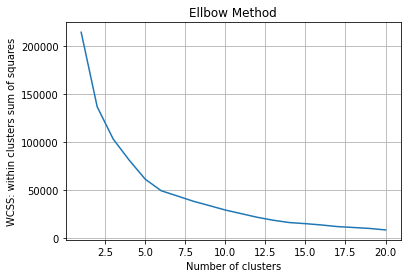

In [32]:
wcss = []
for n in range(1,21):
  kmeans = KMeans(n_clusters=n, random_state=123)
  kmeans.fit(X.sample(frac=1, random_state=123))
  wcss.append(kmeans.inertia_)

plt.plot(range(1,21), wcss)
plt.title('Ellbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS: within clusters sum of squares')
plt.grid('on')
plt.show()

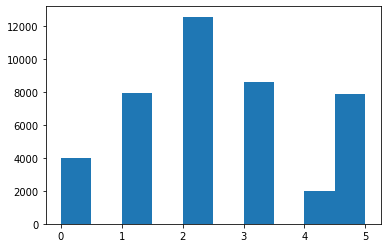

In [33]:
# optimal number of clusters approx. n_clusters=6
kmeans = KMeans(n_clusters=6, random_state=123)
data_csv['cluster'] = kmeans.fit_predict(X)
plt.hist(data_csv['cluster'])
plt.show()

In [34]:
cluster_n = 1
data_csv[data_csv['cluster'] == cluster_n]['location'].unique()

array(['India', 'Kenya', 'Namibia', 'Nepal', 'Nigeria', 'Pakistan',
       'Philippines', 'South Africa', 'Sri Lanka', 'Thailand', 'Zambia',
       'Zimbabwe'], dtype=object)

In [35]:
data_csv.columns

Index(['continent', 'location', 'total_cases_per_million',
       'new_cases_per_million', 'positive_rate', 'tests_per_case',
       'reproduction_rate', 'total_deaths_per_million',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'population_density',
       'median_age', 'aged_65_older', 'life_expectancy', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'human_development_index', 'stringency_index',
       'new_deaths_per_million', 'month', 'facial_coverings',
       'school_closures', 'stay_home_requirements', 'cancel_public_events',
       'testing_policy', 'close_public_transport',
       'public_information_campaigns', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'latitude', 'longitude', 'cluster'],
      dtype='object')

# Filling Remaining Missing Data with Median

In [36]:
use_cols = data_csv.columns[2:]

In [37]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42920 entries, 2020-03-01 to 2021-12-23
Data columns (total 40 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   continent                            42920 non-null  object 
 1   location                             42920 non-null  object 
 2   total_cases_per_million              42920 non-null  float64
 3   new_cases_per_million                42530 non-null  float64
 4   positive_rate                        41068 non-null  float64
 5   tests_per_case                       40936 non-null  float64
 6   reproduction_rate                    41832 non-null  float64
 7   total_deaths_per_million             42920 non-null  float64
 8   total_vaccinations_per_hundred       42920 non-null  float64
 9   people_vaccinated_per_hundred        42920 non-null  float64
 10  people_fully_vaccinated_per_hundred  42920 non-null  float64
 11  population_

In [38]:
for country in data_csv.location.unique():
  # get single country
  df_country = filter_country(data_csv, country)
  # fill missing data of all columns with median values
  df_country = fill_in_median(df_country, use_cols)
  # overwrite orignial values
  data_csv[data_csv['location'] == country] = df_country

Streaming output truncated to the last 5000 lines.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [39]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42920 entries, 2020-03-01 to 2021-12-23
Data columns (total 40 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   continent                            42920 non-null  object 
 1   location                             42920 non-null  object 
 2   total_cases_per_million              42920 non-null  float64
 3   new_cases_per_million                42920 non-null  float64
 4   positive_rate                        42920 non-null  float64
 5   tests_per_case                       42920 non-null  float64
 6   reproduction_rate                    42920 non-null  float64
 7   total_deaths_per_million             42920 non-null  float64
 8   total_vaccinations_per_hundred       42920 non-null  float64
 9   people_vaccinated_per_hundred        42920 non-null  float64
 10  people_fully_vaccinated_per_hundred  42920 non-null  float64
 11  population_

In [40]:
data_csv.isna().sum()

continent                              0
location                               0
total_cases_per_million                0
new_cases_per_million                  0
positive_rate                          0
tests_per_case                         0
reproduction_rate                      0
total_deaths_per_million               0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
population_density                     0
median_age                             0
aged_65_older                          0
life_expectancy                        0
gdp_per_capita                         0
cardiovasc_death_rate                  0
diabetes_prevalence                    0
female_smokers                         0
male_smokers                           0
human_development_index                0
stringency_index                       0
new_deaths_per_million                 0
month                                  0
facial_coverings

# Feature Engineering

In [41]:
# add pct changes to train and test data
data_csv = add_pct_change(data_csv)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Add Target Variable

In [42]:
data_csv = add_target(data_csv)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Remove Outliers!

In [43]:
# to be implemented using feature_engine

# Eliminate Features
## Eliminate Quasi-Constant Features

In [44]:
feature_selector = DropConstantFeatures(variables=None,
                                        tol=0.8)
feature_selector.fit(data_csv)
feature_selector.features_to_drop_                                        

['public_information_campaigns']

## Check for Correlated Features

In [45]:
feature_selector = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.8)
feature_selector.fit(data_csv)
feature_selector.features_to_drop_ 

{'aged_65_older',
 'cluster',
 'grocery_and_pharmacy',
 'human_development_index',
 'life_expectancy',
 'people_fully_vaccinated_per_hundred',
 'people_vaccinated_per_hundred',
 'residential',
 'total_deaths_per_million',
 'transit_stations'}

In [46]:
feature_selector = DropCorrelatedFeatures(variables=None, method='kendall', threshold=0.8)
feature_selector.fit(data_csv)
feature_selector.features_to_drop_

{'human_development_index',
 'people_fully_vaccinated_per_hundred',
 'people_vaccinated_per_hundred',
 'tests_per_case',
 'tests_per_case_pct_change'}

In [47]:
feature_selector = DropCorrelatedFeatures(variables=None, method='spearman', threshold=0.8)
feature_selector.fit(data_csv)
feature_selector.features_to_drop_

{'aged_65_older',
 'grocery_and_pharmacy',
 'human_development_index',
 'new_cases_per_million_pct_change',
 'new_deaths_per_million_future',
 'people_fully_vaccinated_per_hundred',
 'people_vaccinated_per_hundred',
 'residential',
 'tests_per_case',
 'tests_per_case_pct_change',
 'total_deaths_per_million',
 'transit_stations'}

In [48]:
#data_csv = data_csv.drop(columns=['human_development_index',
#                                  'people_fully_vaccinated_per_hundred',
#                                  'tests_per_case_pct_change',
#                                  'total_deaths_per_million',
#                                  'public_information_campaigns'])

# Explore Single Country

In [49]:
country = 'Germany'
#country = 'Sweden'
df_country = filter_country(data_csv, country)

In [50]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 628 entries, 2020-03-08 to 2021-11-25
Data columns (total 47 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   continent                            628 non-null    object 
 1   location                             628 non-null    object 
 2   total_cases_per_million              628 non-null    float64
 3   new_cases_per_million                628 non-null    float64
 4   positive_rate                        628 non-null    float64
 5   tests_per_case                       628 non-null    float64
 6   reproduction_rate                    628 non-null    float64
 7   total_deaths_per_million             628 non-null    float64
 8   total_vaccinations_per_hundred       628 non-null    float64
 9   people_vaccinated_per_hundred        628 non-null    float64
 10  people_fully_vaccinated_per_hundred  628 non-null    float64
 11  population_de

In [51]:
df_country.describe()

total_cases_per_million  new_cases_per_million  positive_rate  \
count               628.000000             628.000000     628.000000   
mean              23676.628247             103.095032       0.061078   
std               20081.383547             107.891526       0.043532   
min                   5.124429               1.250286       0.006000   
25%                2584.563214              14.717893       0.015061   
50%               23382.253286              75.853857       0.064133   
75%               44599.538429             173.768500       0.089097   
max               64747.547286             648.160571       0.197327   

       tests_per_case  reproduction_rate  total_deaths_per_million  \
count      628.000000         628.000000                628.000000   
mean        40.986660           1.100739                566.488352   
std         43.333026           0.376487                457.741999   
min          5.081633           0.518571                  0.024000   
25%         11.242347           0.883571                110.204750   
50%         15.611224           1.064286                508.759000   
75%         67.777551           1.246071               1082.010929   
max        166.700000           2.938571               1190.751429   

       total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
count                      628.000000                     628.000000   
mean                        36.958258                      21.113273   
std                         51.949832                      28.108273   
min                          0.000000                       0.000000   
25%                          0.000000                       0.000000   
50%                          1.070000                       1.069286   
75%                         80.395000                      51.553571   
max                        145.374286                      71.657143   

       people_fully_vaccinated_per_hundred  population_density  ...  \
count                           628.000000        6.280000e+02  ...   
mean                             16.181056        2.370160e+02  ...   
std                              24.711408        2.011320e-14  ...   
min                               0.000000        2.370160e+02  ...   
25%                               0.000000        2.370160e+02  ...   
50%                               0.000000        2.370160e+02  ...   
75%                              30.482143        2.370160e+02  ...   
max                              67.728571        2.370160e+02  ...   

         latitude     longitude  cluster  new_cases_per_million_pct_change  \
count  628.000000  6.280000e+02    628.0                        628.000000   
mean    51.163818  1.044783e+01      3.0                          0.133530   
std      0.000000  1.777773e-15      0.0                          0.568845   
min     51.163818  1.044783e+01      3.0                         -0.985664   
25%     51.163818  1.044783e+01      3.0                         -0.171289   
50%     51.163818  1.044783e+01      3.0                          0.060086   
75%     51.163818  1.044783e+01      3.0                          0.290419   
max     51.163818  1.044783e+01      3.0                          4.467207   

       positive_rate_pct_change  tests_per_case_pct_change  \
count                628.000000                 628.000000   
mean                   0.033868                   0.009782   
std                    0.211385                   0.214166   
min                   -0.408654                  -0.336154   
25%                   -0.124668                  -0.143158   
50%                    0.032739                  -0.030427   
75%                    0.168008                   0.140559   
max                    0.509249                   0.598252   

       reproduction_rate_pct_change  stringency_index_pct_change  \
count                    628.000000                   628.000000   
mean                       0.014664     

In [52]:
df_country.tail()

continent location  total_cases_per_million  new_cases_per_million  \
date                                                                            
2021-11-21    Europe  Germany             62280.215429             571.152571   
2021-11-22    Europe  Germany             62863.418714             583.203286   
2021-11-23    Europe  Germany             63469.363857             605.945000   
2021-11-24    Europe  Germany             64099.386571             630.022714   
2021-11-25    Europe  Germany             64747.547286             648.160571   

            positive_rate  tests_per_case  reproduction_rate  \
date                                                           
2021-11-21       0.185286        5.400000           1.305714   
2021-11-22       0.188633        5.308163           1.295714   
2021-11-23       0.191755        5.224490           1.284286   
2021-11-24       0.194653        5.148980           1.272857   
2021-11-25       0.197327        5.081633           1.260000   

            total_deaths_per_million  total_vaccinations_per_hundred  \
date                                                                   
2021-11-21               1180.583000                      142.912857   
2021-11-22               1182.996143                      143.437143   
2021-11-23               1185.484714                      144.017143   
2021-11-24               1188.043571                      144.668571   
2021-11-25               1190.751429                      145.374286   

            people_vaccinated_per_hundred  ...   latitude  longitude  cluster  \
date                                       ...                                  
2021-11-21                      71.297143  ...  51.163818  10.447831        3   
2021-11-22                      71.371429  ...  51.163818  10.447831        3   
2021-11-23                      71.455714  ...  51.163818  10.447831        3   
2021-11-24                      71.551429  ...  51.163818  10.447831        3   
2021-11-25                      71.657143  ...  51.163818  10.447831        3   

            new_cases_per_million_pct_change  positive_rate_pct_change  \
date                                                                     
2021-11-21                          0.310636                  0.120035   
2021-11-22                          0.297028                  0.125959   
2021-11-23                          0.297130                  0.128784   
2021-11-24                          0.286639                  0.128624   
2021-11-25                          0.256962                  0.125611   

            tests_per_case_pct_change  reproduction_rate_pct_change  \
date                                                                  
2021-11-21                  -0.102138                     -0.048907   
2021-11-22                  -0.106186                     -0.052247   
2021-11-23                  -0.108325                     -0.055672   
2021-11-24                  -0.108481                     -0.057143   
2021-11-25                  -0.106566                     -0.058698   

            stringency_index_pct_change  new_deaths_per_million_pct_change  \
date                                                                         
2021-11-21                     0.065498                           0.211912   
2021-11-22                     0.050801                           0.217793   
2021-11-23                     0.036560                           0.159633   
2021-11-24                     0.028517                           0.139522   
2021-11-25                     0.020626                           0.179758   

            new_deaths_per_million_future  
date                                       
2021-11-21                       4.444571  
2021-11-22                       4.449714  
2021-11-23                       4.430857  
2021-11-24                       4.528429  
2021-11-25                       4.362286  

[5 rows x 47 columns]

In [53]:
df_country.columns[2:]

Index(['total_cases_per_million', 'new_cases_per_million', 'positive_rate',
       'tests_per_case', 'reproduction_rate', 'total_deaths_per_million',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'population_density',
       'median_age', 'aged_65_older', 'life_expectancy', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'human_development_index', 'stringency_index',
       'new_deaths_per_million', 'month', 'facial_coverings',
       'school_closures', 'stay_home_requirements', 'cancel_public_events',
       'testing_policy', 'close_public_transport',
       'public_information_campaigns', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'latitude', 'longitude', 'cluster',
       'new_cases_per_million_pct_change', 'positive_rate_pct_change',
       'tests_per_case_pct_change'

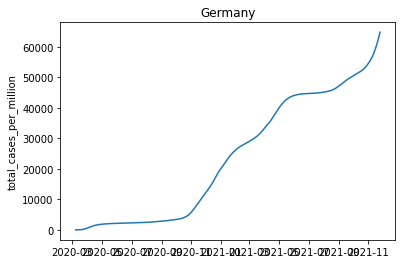

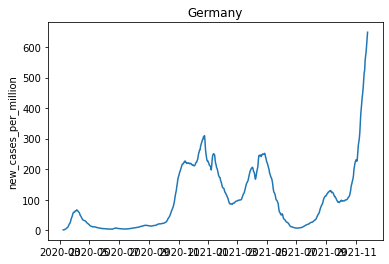

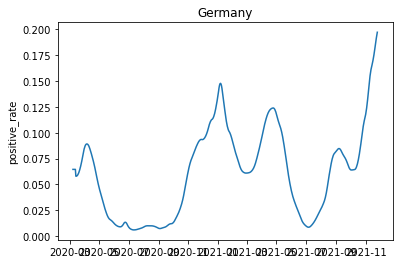

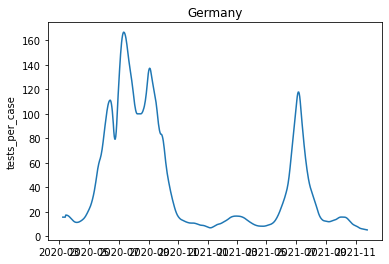

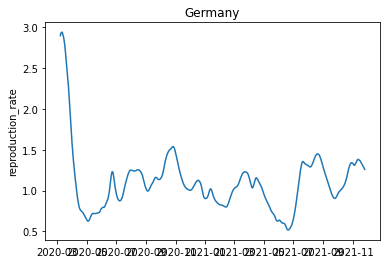

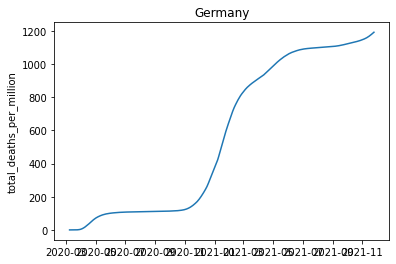

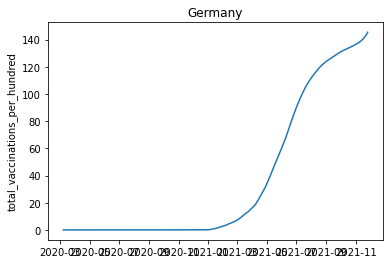

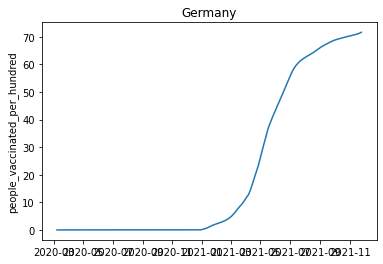

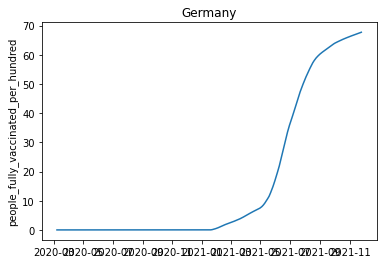

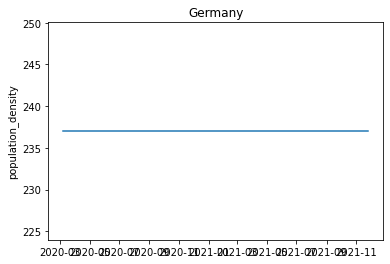

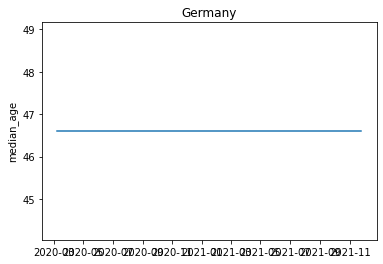

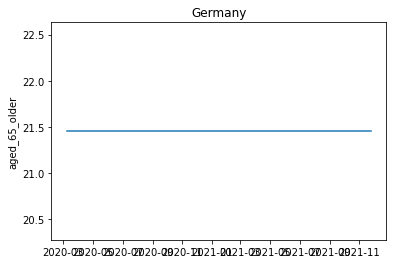

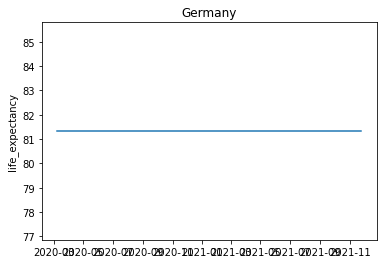

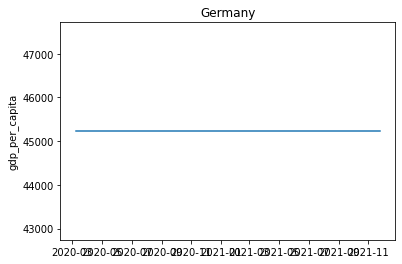

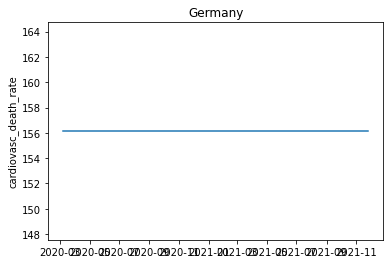

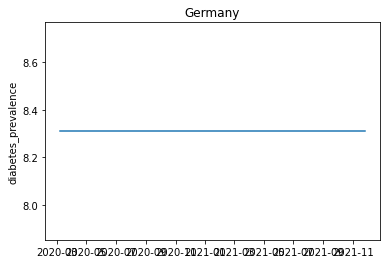

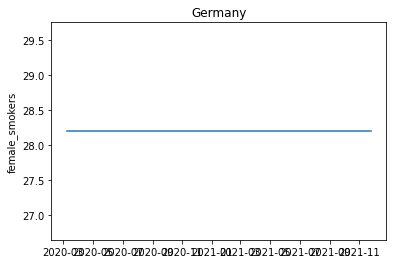

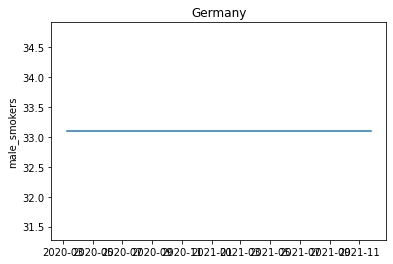

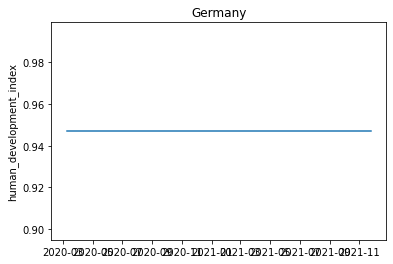

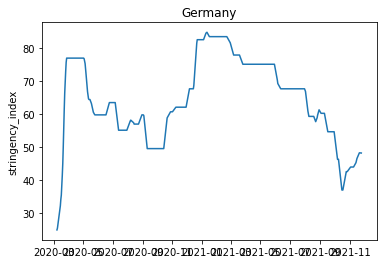

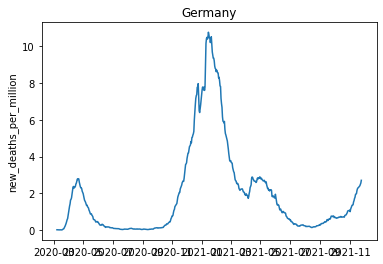

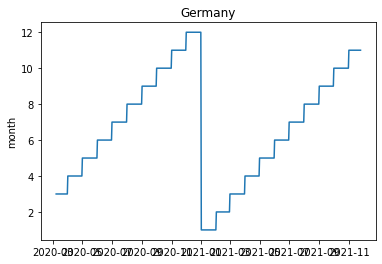

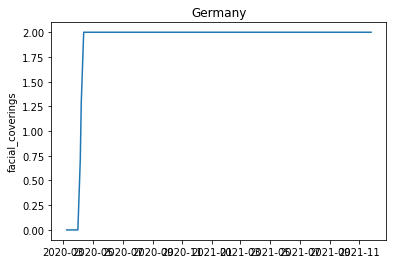

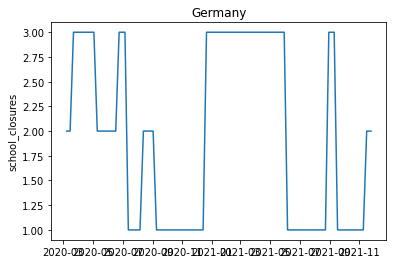

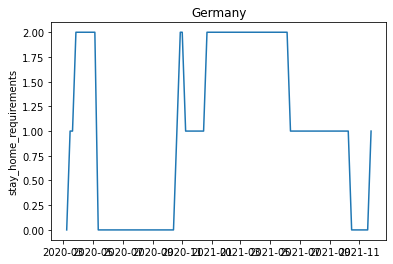

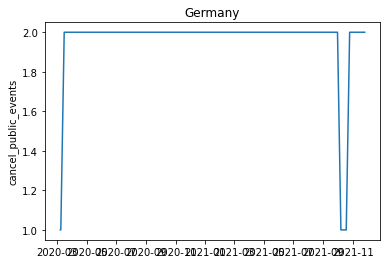

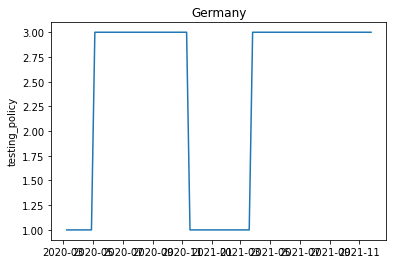

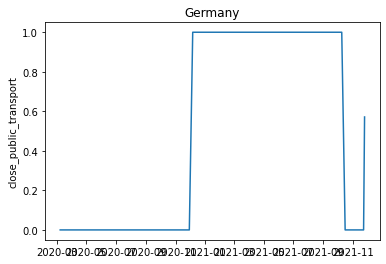

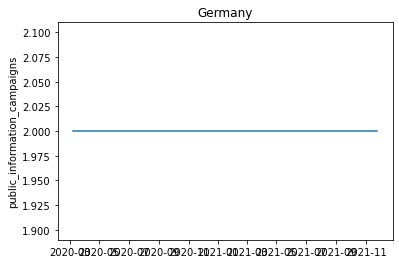

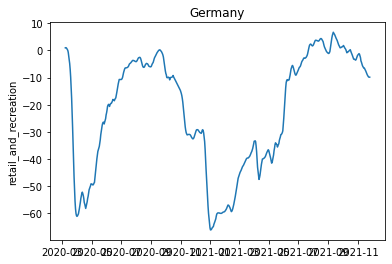

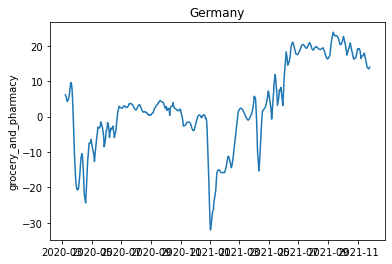

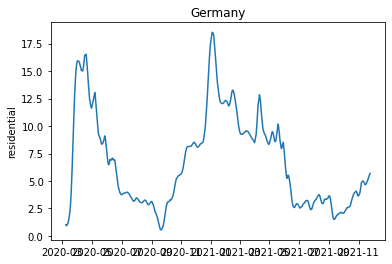

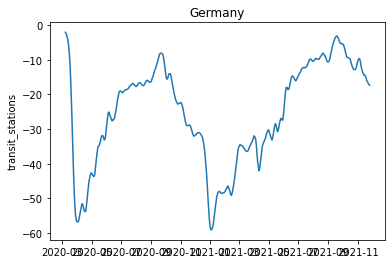

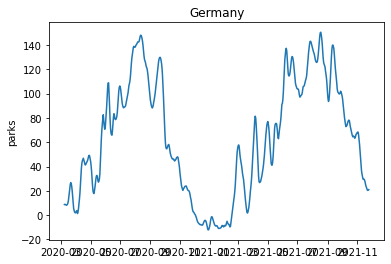

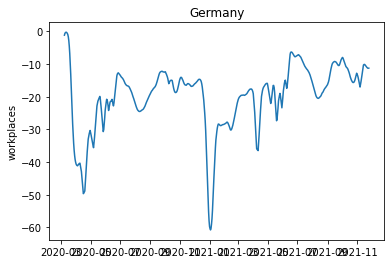

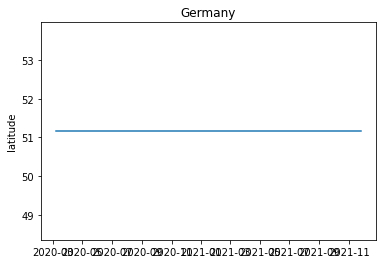

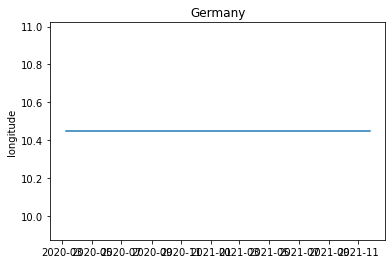

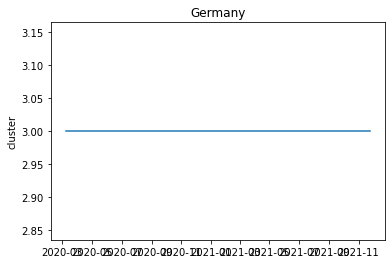

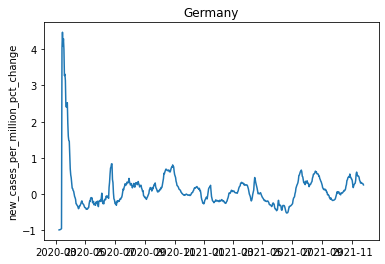

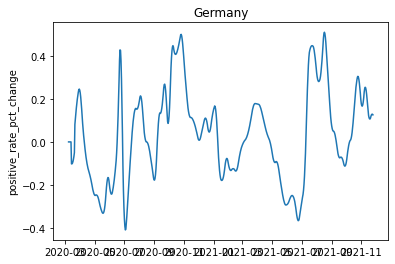

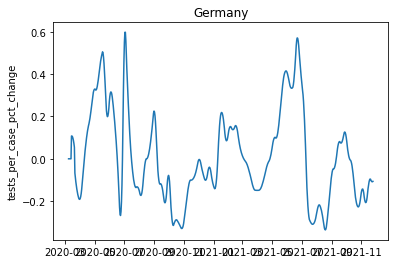

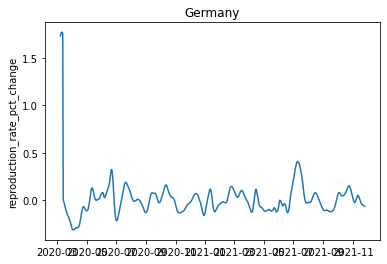

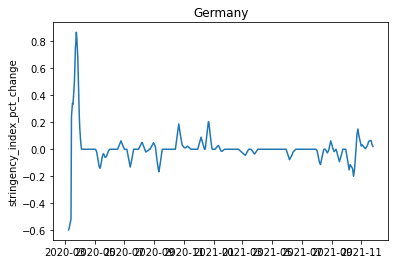

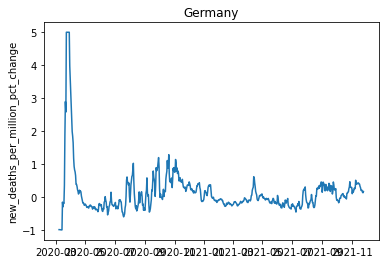

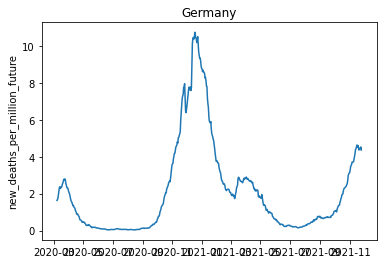

In [54]:
# plot curves
for col in df_country.columns[2:]:
  plt.plot(df_country[col])
  plt.title(country)
  plt.ylabel(col)
  plt.show()

# Modeling

In [55]:
features = data_csv.columns[2:-1]
target = data_csv.columns[-1]

X = data_csv[features]
y = data_csv[target]

In [56]:
# init model
reg = xgboost.XGBRegressor(max_depth=3, 
                           learning_rate=0.1, 
                           n_estimators=100,
                           subsample= 1,
                           n_jobs=-1)

In [57]:
features

Index(['total_cases_per_million', 'new_cases_per_million', 'positive_rate',
       'tests_per_case', 'reproduction_rate', 'total_deaths_per_million',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'population_density',
       'median_age', 'aged_65_older', 'life_expectancy', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'human_development_index', 'stringency_index',
       'new_deaths_per_million', 'month', 'facial_coverings',
       'school_closures', 'stay_home_requirements', 'cancel_public_events',
       'testing_policy', 'close_public_transport',
       'public_information_campaigns', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'latitude', 'longitude', 'cluster',
       'new_cases_per_million_pct_change', 'positive_rate_pct_change',
       'tests_per_case_pct_change'

## Cross Validation

In [58]:
from sklearn.model_selection import GroupKFold, cross_validate

In [59]:
group_kfold = GroupKFold(n_splits=5)

In [60]:
groups = data_csv['location']

In [61]:
train_indices = []
test_indices = []
for train_index, test_index in group_kfold.split(X, y, groups):
  print("TRAIN:", train_index, "TEST:", test_index)
  train_indices.append(train_index)
  test_indices.append(test_index)

TRAIN: [  628   629   630 ... 39530 39531 39532] TEST: [    0     1     2 ... 37764 37765 37766]
TRAIN: [    0     1     2 ... 38968 38969 38970] TEST: [ 3058  3059  3060 ... 39530 39531 39532]
TRAIN: [    0     1     2 ... 39530 39531 39532] TEST: [ 1809  1810  1811 ... 31791 31792 31793]
TRAIN: [    0     1     2 ... 39530 39531 39532] TEST: [  628   629   630 ... 36508 36509 36510]
TRAIN: [    0     1     2 ... 39530 39531 39532] TEST: [ 2430  2431  2432 ... 38968 38969 38970]


In [62]:
data_csv['location'][train_indices[4]].unique()

array(['Argentina', 'Australia', 'Bahrain', 'Bangladesh', 'Bulgaria',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Czechia', 'Denmark',
       'Dominican Republic', 'Ecuador', 'El Salvador', 'Finland',
       'Germany', 'Greece', 'Hungary', 'India', 'Israel', 'Jamaica',
       'Japan', 'Lithuania', 'Luxembourg', 'Malaysia', 'Malta', 'Mexico',
       'Namibia', 'Nepal', 'Nigeria', 'Norway', 'Pakistan', 'Panama',
       'Paraguay', 'Philippines', 'Poland', 'Portugal', 'Saudi Arabia',
       'Serbia', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea',
       'Sri Lanka', 'Sweden', 'Switzerland', 'Thailand',
       'United Arab Emirates', 'United Kingdom', 'United States',
       'Uruguay', 'Zimbabwe'], dtype=object)

In [63]:
data_csv['location'][test_indices[4]].unique()

array(['Belgium', 'Croatia', 'Estonia', 'France', 'Ireland', 'Italy',
       'Kenya', 'Latvia', 'Netherlands', 'Romania', 'Spain', 'Turkey',
       'Zambia'], dtype=object)

In [64]:
# save training and test countries in lists
train_countries = []
test_countries = []
for cv in range(5):
  # make lists of countries and their according cross val set number
  train_countries.append(data_csv['location'][train_indices[cv]].unique())
  test_countries.append(data_csv['location'][test_indices[cv]].unique())
# check results
test_countries

[array(['Argentina', 'Czechia', 'El Salvador', 'Israel', 'Luxembourg',
        'Malaysia', 'Mexico', 'Norway', 'Panama', 'Saudi Arabia',
        'Sri Lanka', 'Switzerland', 'United States'], dtype=object),
 array(['Bulgaria', 'Canada', 'Costa Rica', 'Ecuador', 'Hungary', 'India',
        'Portugal', 'Slovenia', 'Sweden', 'Thailand', 'United Kingdom',
        'Uruguay', 'Zimbabwe'], dtype=object),
 array(['Bangladesh', 'Chile', 'Greece', 'Lithuania', 'Malta', 'Nepal',
        'Pakistan', 'Paraguay', 'Philippines', 'Poland', 'Serbia',
        'Slovakia', 'South Africa'], dtype=object),
 array(['Australia', 'Bahrain', 'Colombia', 'Denmark',
        'Dominican Republic', 'Finland', 'Germany', 'Jamaica', 'Japan',
        'Namibia', 'Nigeria', 'South Korea', 'United Arab Emirates'],
       dtype=object),
 array(['Belgium', 'Croatia', 'Estonia', 'France', 'Ireland', 'Italy',
        'Kenya', 'Latvia', 'Netherlands', 'Romania', 'Spain', 'Turkey',
        'Zambia'], dtype=object)]

# Check Predictive Power of Features

In [65]:
from sklearn.feature_selection import RFECV

In [66]:
min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(estimator=reg,
              step=1,
              cv=group_kfold,
              scoring='r2',
              n_jobs=-1,
              min_features_to_select=min_features_to_select)

rfecv.fit(X, y, groups=groups)

[08:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

RFECV(cv=GroupKFold(n_splits=5), estimator=XGBRegressor(n_jobs=-1), n_jobs=-1,
      scoring='r2')

In [67]:
print('The total number of features is: {}'.format(len(features)))
print('The optimal number of features is: {}'.format(rfecv.n_features_))

The total number of features is: 44
The optimal number of features is: 34


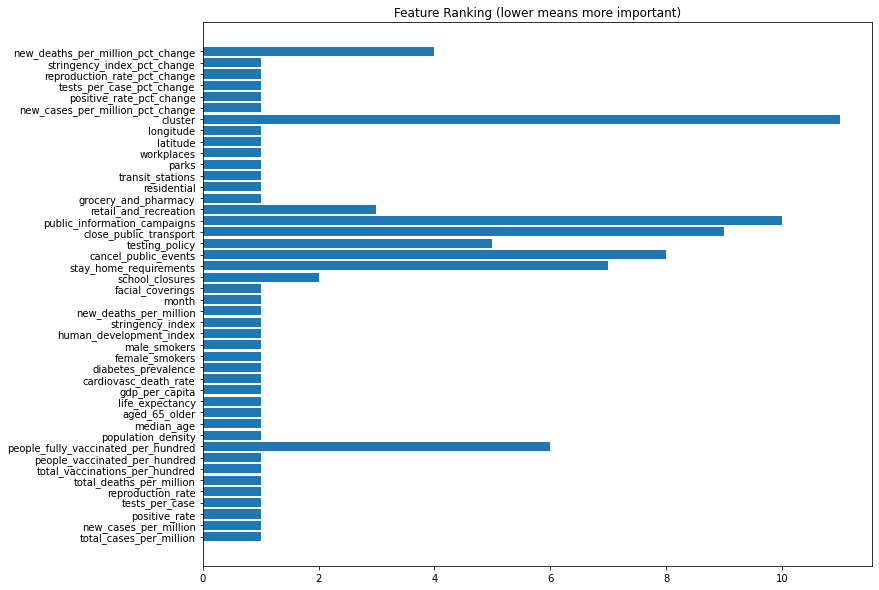

In [68]:
plt.figure(figsize=(12,10))
plt.barh(y=rfecv.feature_names_in_, width=rfecv.ranking_)
plt.title('Feature Ranking (lower means more important)')
plt.show()

The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.


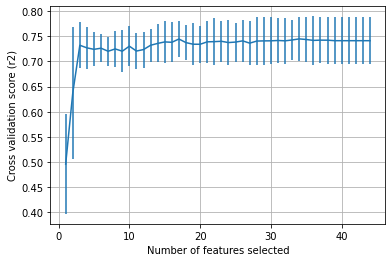

In [69]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (r2)")
plt.errorbar(x=range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), 
             y=rfecv.cv_results_['mean_test_score'], 
             yerr=rfecv.cv_results_['std_test_score'])
plt.grid('on')
plt.show()

## Hyperparameter Tuning

In [70]:
from sklearn.model_selection import GridSearchCV

In [71]:
grid = {'max_depth': [3, 4, 5],
        'n_estimators': [50, 100],
        'learning_rate':[0.025, 0.05, 0.1],
        'subsample': [0.1, 0.5, 1]}

In [72]:
grid_search_results = GridSearchCV(estimator=reg, 
                                   param_grid=grid,
                                   scoring='r2', 
                                   n_jobs=-1, 
                                   cv=group_kfold, 
                                   return_train_score=True)

In [73]:
grid_search_results.fit(X, y, groups=groups)

[09:08:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=GroupKFold(n_splits=5), estimator=XGBRegressor(n_jobs=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.025, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100],
                         'subsample': [0.1, 0.5, 1]},
             return_train_score=True, scoring='r2')

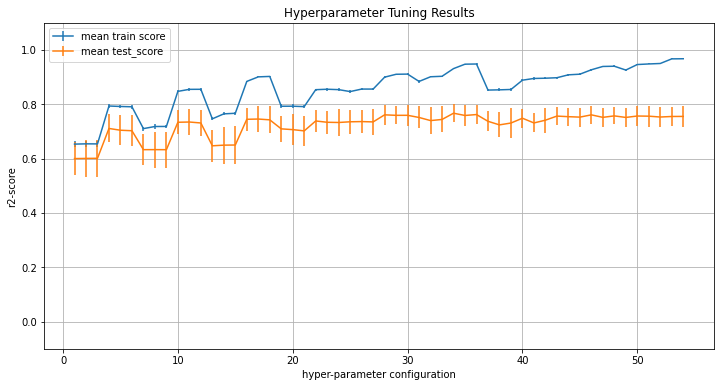

In [74]:
plt.figure(figsize=(12,6))
x_train = range(1, len(grid_search_results.cv_results_['mean_train_score'])+1)
y_train = grid_search_results.cv_results_['mean_train_score']
y_train_std = grid_search_results.cv_results_['std_train_score']

x_test = range(1, len(grid_search_results.cv_results_['mean_test_score'])+1)
y_test = grid_search_results.cv_results_['mean_test_score']
y_test_std = grid_search_results.cv_results_['std_test_score']

plt.errorbar(x_train, y_train, y_train_std)
plt.errorbar(x_test, y_test, y_test_std)
plt.title('Hyperparameter Tuning Results')
plt.legend(['mean train score', 'mean test_score'])
plt.ylabel('r2-score')
plt.xlabel('hyper-parameter configuration')
plt.grid('on')
plt.ylim([-.1,1.1])
plt.show()

In [75]:
grid_search_results.cv_results_['params'][36]

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.1}

In [76]:
print('Best parameter set: {}'.format(grid_search_results.best_params_)) 

Best parameter set: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.1}


Cross validation set: # 0
[09:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 on train data: 0.8501903109665602
R2 on test data: 0.7441289332211543


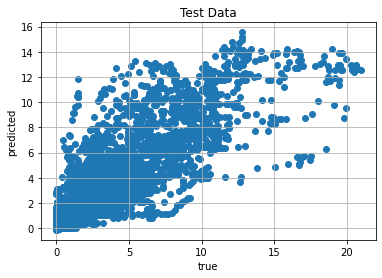

Cross validation set: # 1
[09:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 on train data: 0.8506268553739627
R2 on test data: 0.7302379710142763


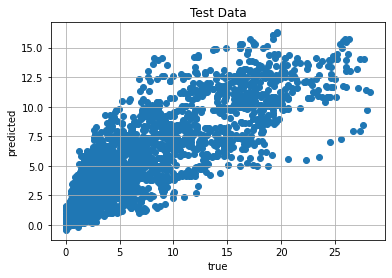

Cross validation set: # 2
[09:08:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 on train data: 0.8491241413183546
R2 on test data: 0.803738065466812


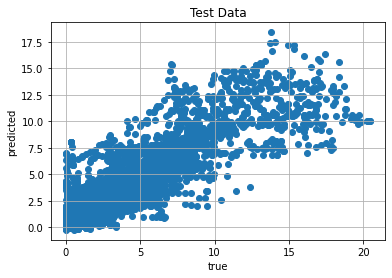

Cross validation set: # 3
[09:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 on train data: 0.8492903544349356
R2 on test data: 0.7015106801245872


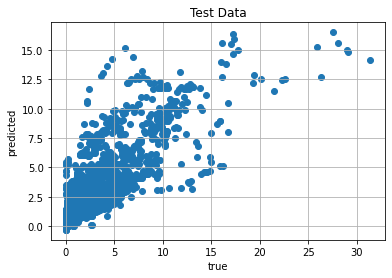

Cross validation set: # 4
[09:08:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 on train data: 0.860235760603693
R2 on test data: 0.7053975697672237


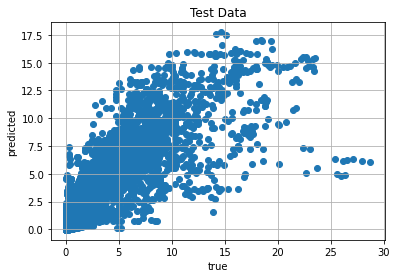

In [77]:
# train a model for each cross validation set
models = []
# iterate of over all val sets
for cv in range(5):
  print('Cross validation set: # {}'.format(cv))
  # get training data
  indices = data_csv['location'].isin(train_countries[cv])
  X_train = data_csv[indices][features]
  y_train = data_csv[indices][target]
  # get testing data
  indices = data_csv['location'].isin(test_countries[cv])
  X_test = data_csv[indices][features]
  y_test = data_csv[indices][target]
  # init model using best hyperparameters to reduce overfitting
  reg_tuned = xgboost.XGBRegressor(max_depth=3, 
                           learning_rate=0.1, 
                           n_estimators=50,
                           subsample=0.1,
                           n_jobs=-1)
  # fit model
  reg_tuned.fit(X_train, y_train)
  # check performance
  print('R2 on train data: {}'.format(reg_tuned.score(X_train, y_train)))
  print('R2 on test data: {}'.format(reg_tuned.score(X_test, y_test)))
  # save model
  models.append(reg_tuned)
  # visualize model performance
  plt.scatter(y_test, reg_tuned.predict(X_test))
  plt.title('Test Data')
  plt.xlabel('true')
  plt.ylabel('predicted')
  plt.grid('on')
  plt.show()

# Training on all countries with hyperparameters chosen to minimze overfitting while maintainining good performance

In [78]:
# make feature and target data
X = data_csv[features]
y = data_csv[target]

In [79]:
reg_tuned = xgboost.XGBRegressor(max_depth=3, 
                                  learning_rate=0.1, 
                                  n_estimators=50,
                                  subsample=0.1,
                                  n_jobs=-1)

In [80]:
# fit model
reg_tuned.fit(X, y)
# check performance
print('R2 on train data: {}'.format(reg_tuned.score(X, y)))

[09:08:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 on train data: 0.8419453352706596


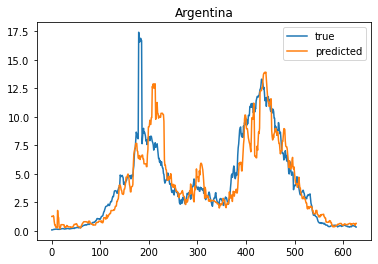

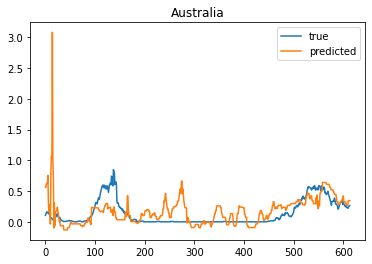

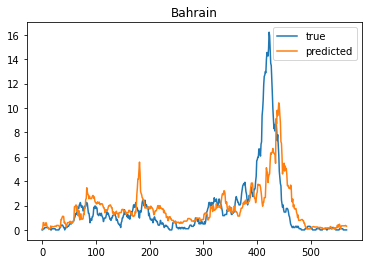

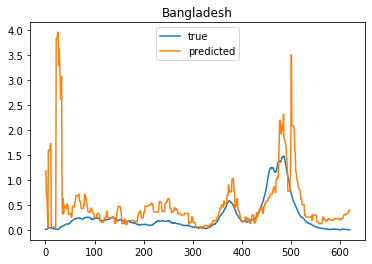

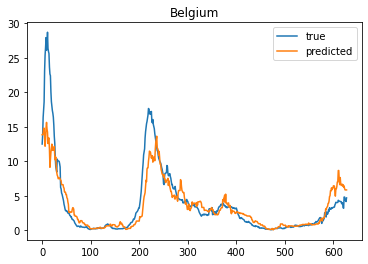

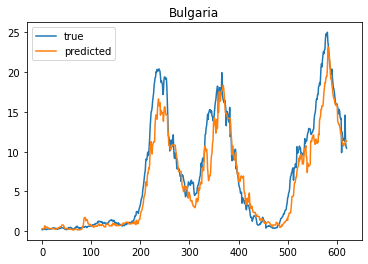

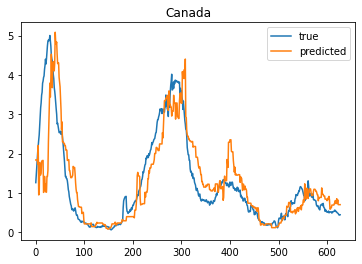

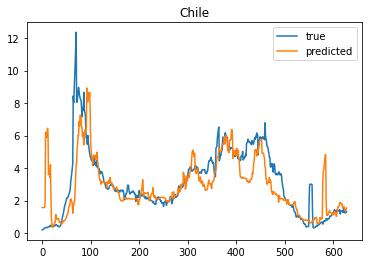

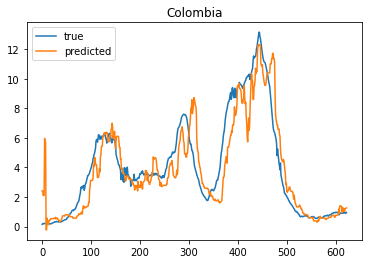

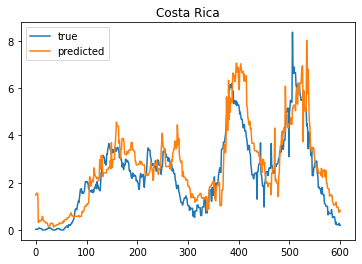

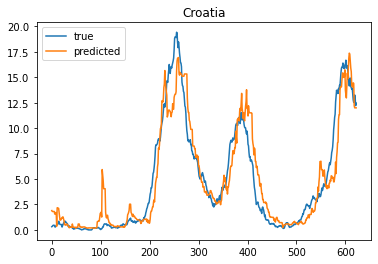

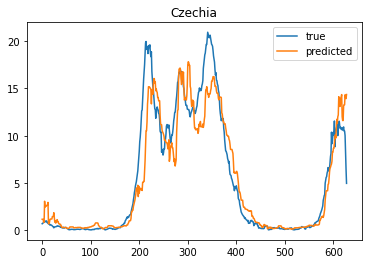

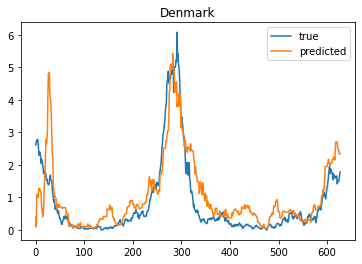

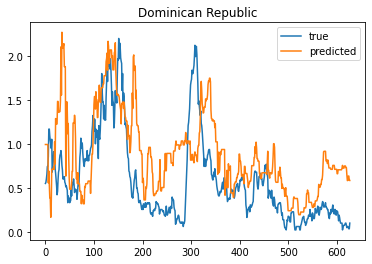

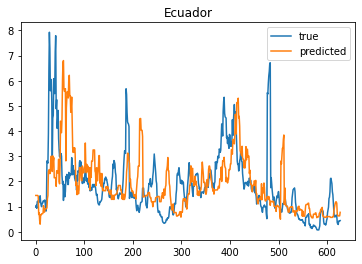

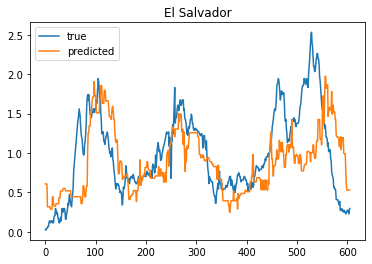

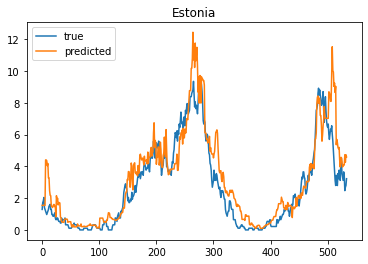

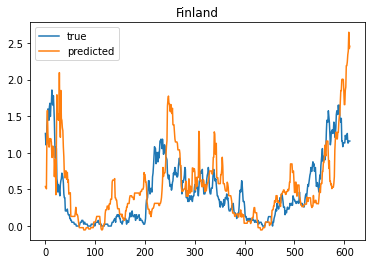

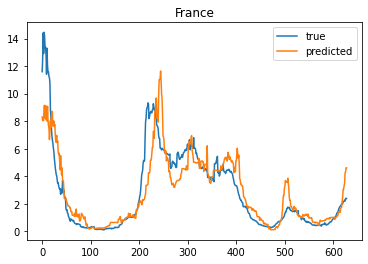

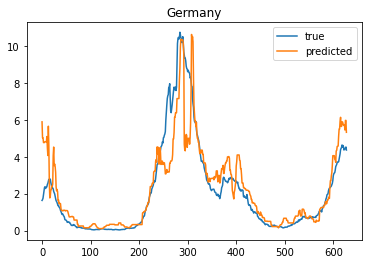

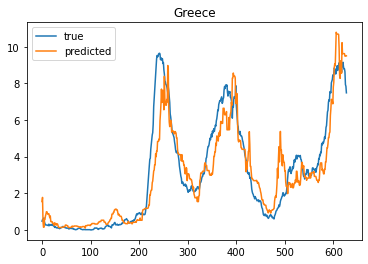

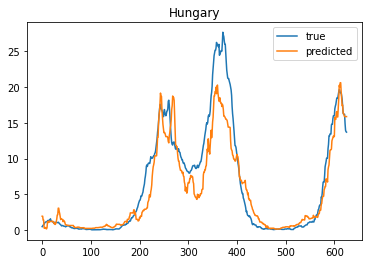

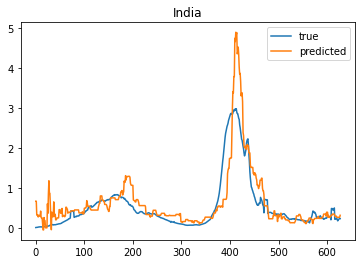

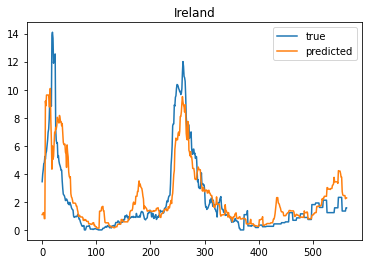

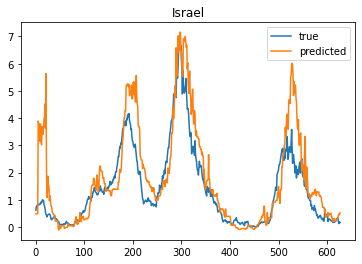

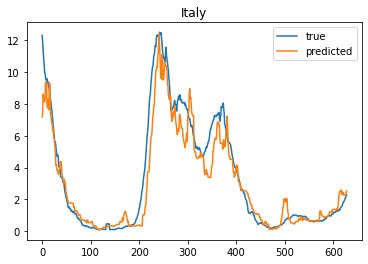

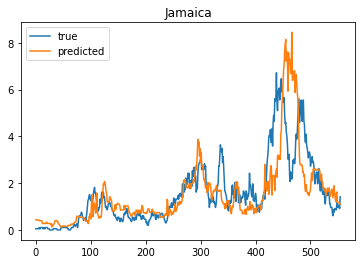

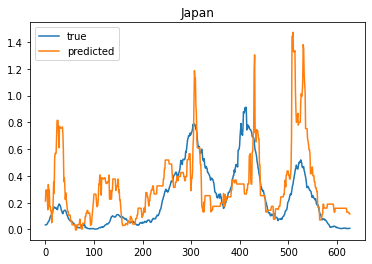

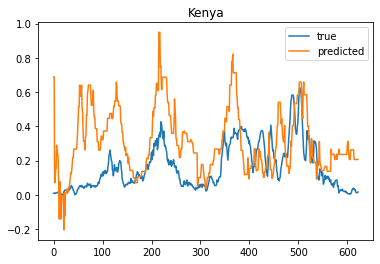

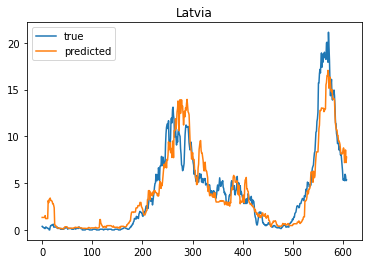

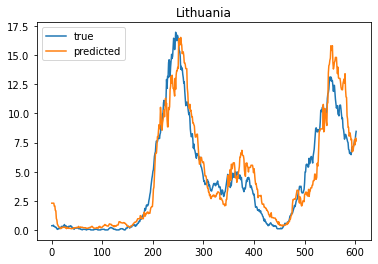

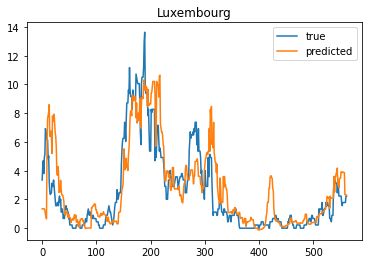

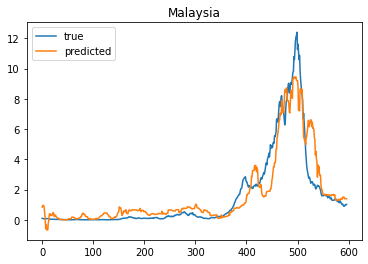

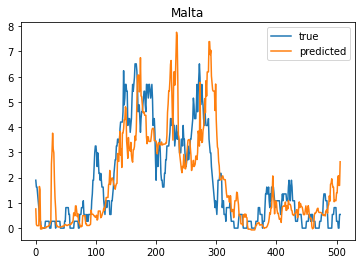

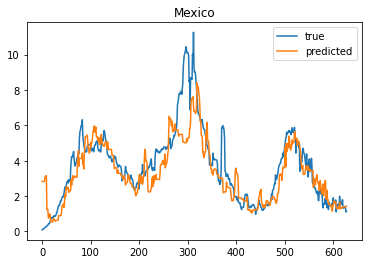

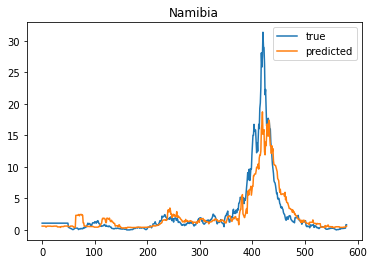

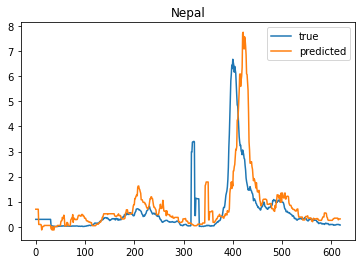

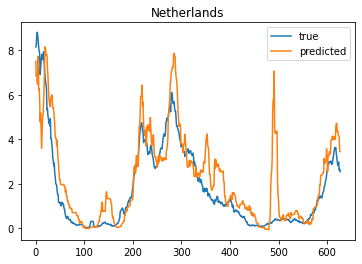

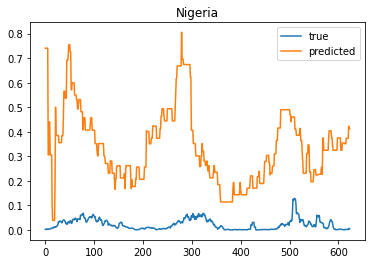

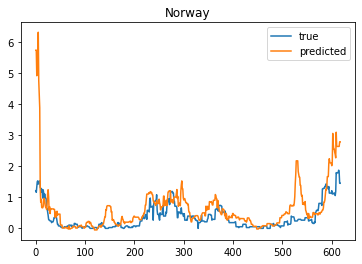

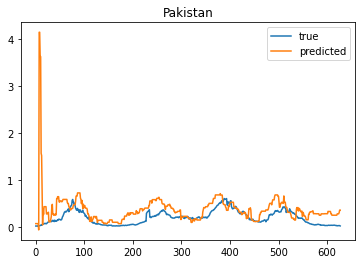

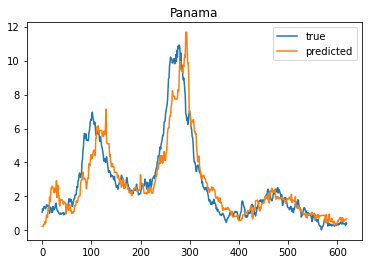

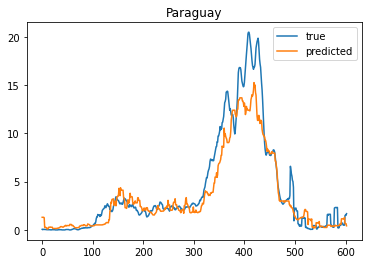

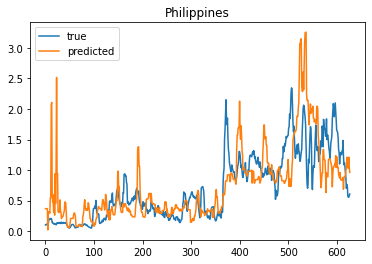

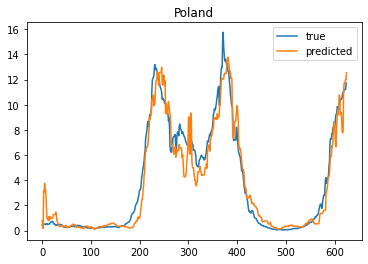

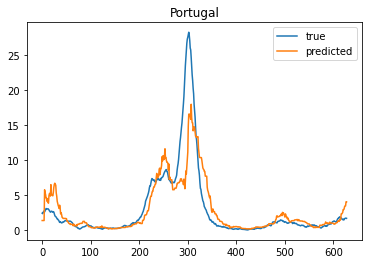

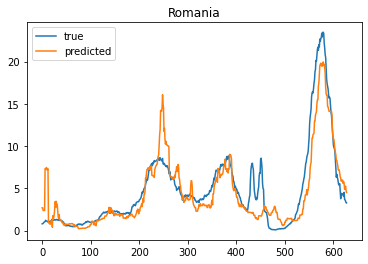

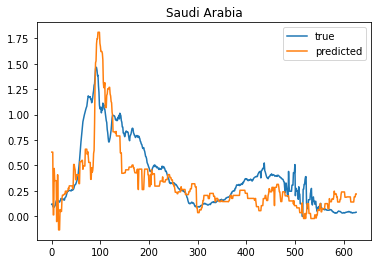

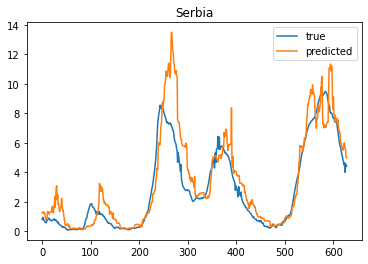

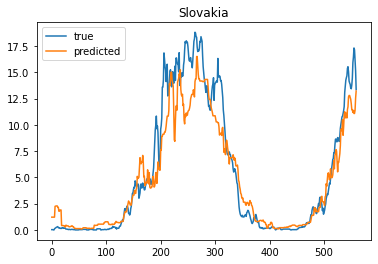

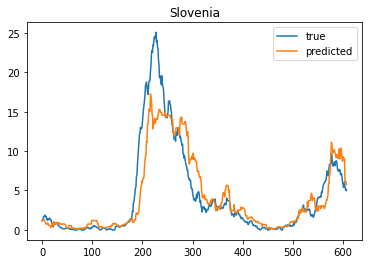

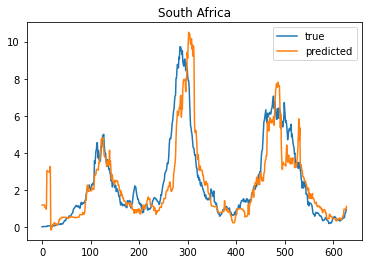

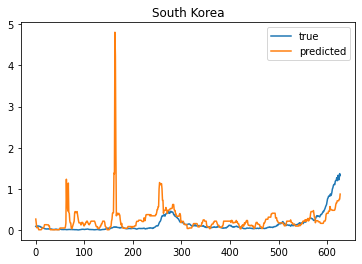

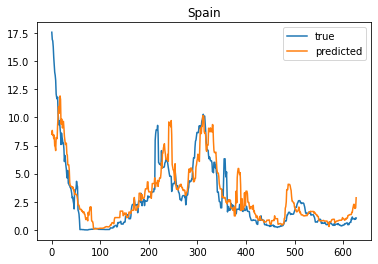

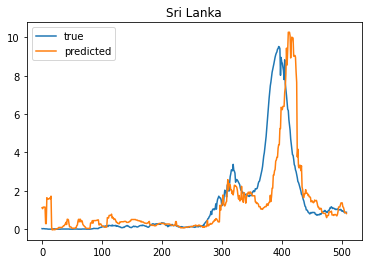

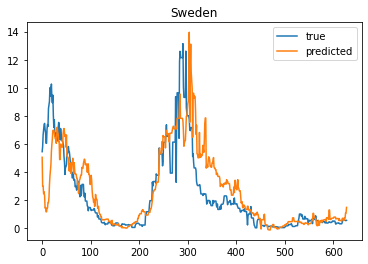

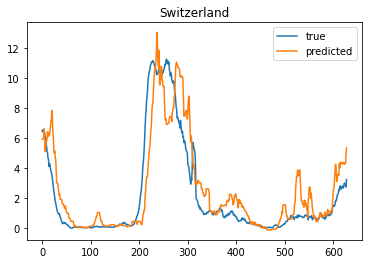

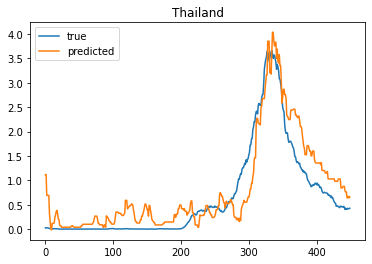

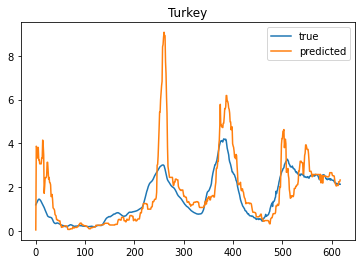

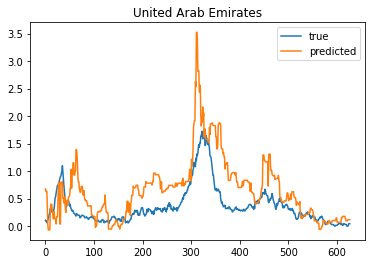

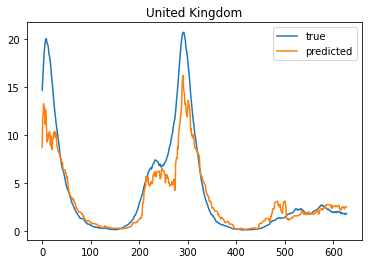

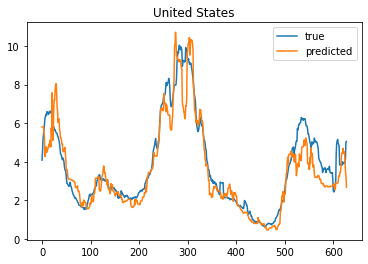

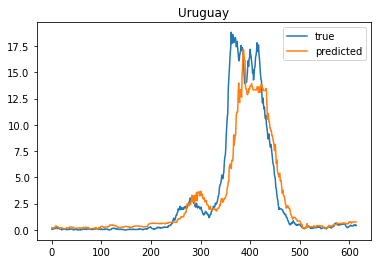

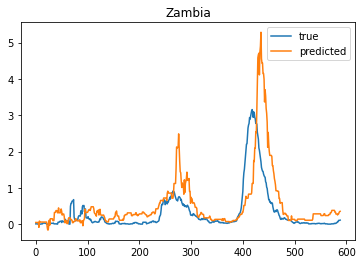

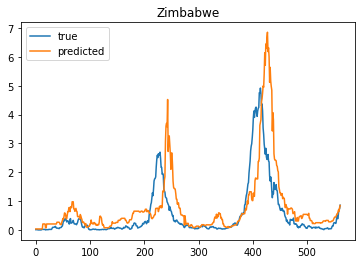

In [81]:
for country in data_csv.location.unique():
  df_country = filter_country(data_csv, country)

  X = df_country[features]
  y = df_country[target].values
  pred = reg_tuned.predict(X)

  plt.plot(y)
  plt.plot(pred)
  plt.legend(['true', 'predicted'])
  plt.title(country)
  plt.show()

# Explaine Regressor Using SHAP

## Cross-Country Analysis - Global Explanations

In [82]:
# make feature and target data
X = data_csv[features]
y = data_csv[target]

# Explain model output using Tree Explainer
explainer = shap.TreeExplainer(model=reg_tuned)
shap_values = explainer(X, check_additivity=True)

# save shapley values values and shapley values data in seperate dataframes
shav_data_df = pd.DataFrame(explainer(X).data, columns = X.columns)
shav_values_df = pd.DataFrame(explainer(X).values, columns = X.columns)

# cluster features based on model loss
#clustering = shap.utils.hclust(X.sample(frac=.02, random_state=123), y.sample(frac=.02, random_state=123))

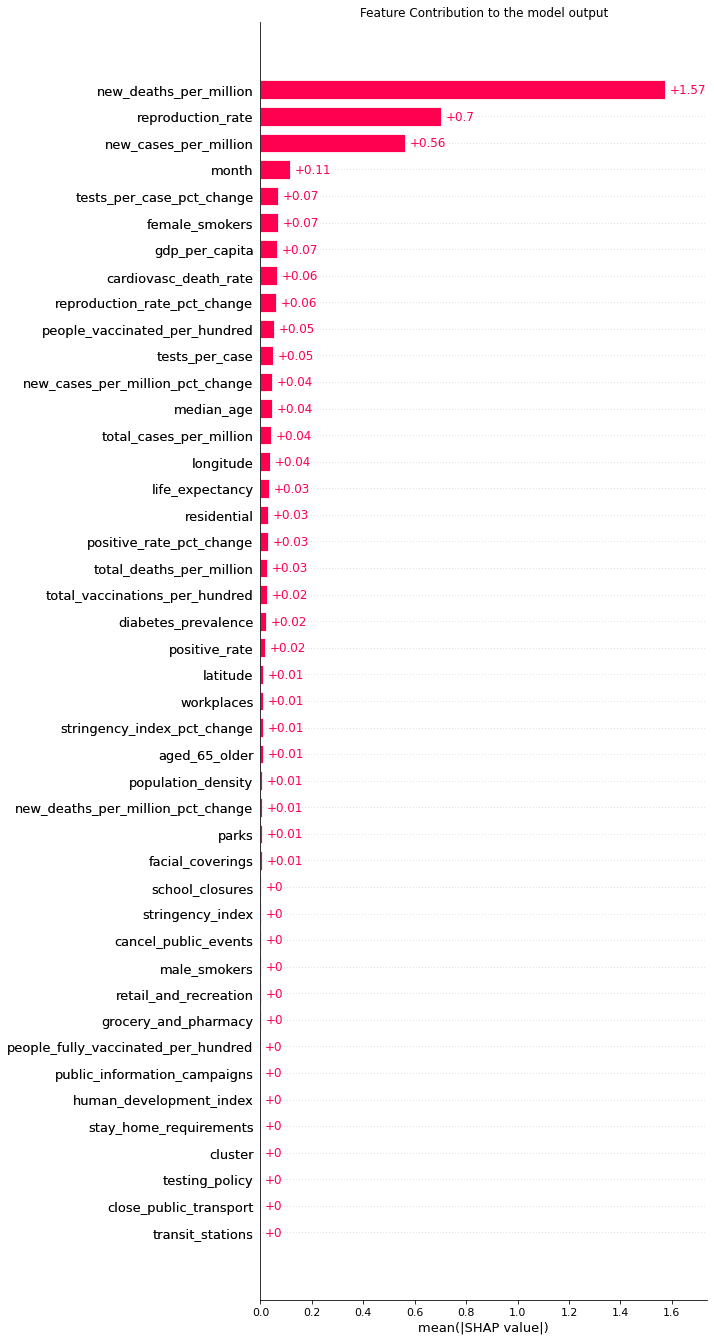

In [83]:
#shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.2, merge_cohorts=True, max_display=44)
plt.figure(figsize=(10,8))
plt.title('Feature Contribution to the model output')
shap.plots.bar(shap_values, max_display=44, show=False)
plt.show()

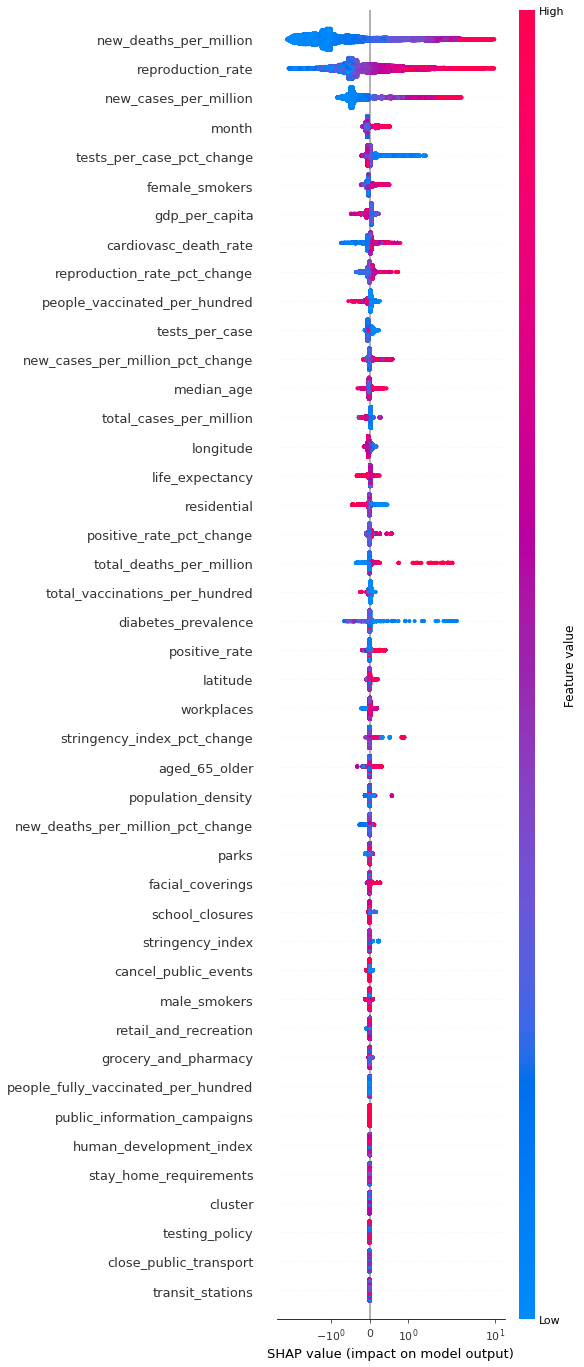

In [84]:
shap.summary_plot(shap_values.values, 
                  features=X, 
                  feature_names=shap_values.feature_names, 
                  max_display=44,
                  use_log_scale=True)

In [85]:
use_cols = policy_vars+['stringency_index'] + mobility_vars + vaccination_vars
use_cols

['facial_coverings',
 'school_closures',
 'stay_home_requirements',
 'cancel_public_events',
 'testing_policy',
 'close_public_transport',
 'public_information_campaigns',
 'stringency_index',
 'retail_and_recreation',
 'grocery_and_pharmacy',
 'residential',
 'transit_stations',
 'parks',
 'workplaces',
 'total_vaccinations_per_hundred',
 'people_vaccinated_per_hundred',
 'people_fully_vaccinated_per_hundred']

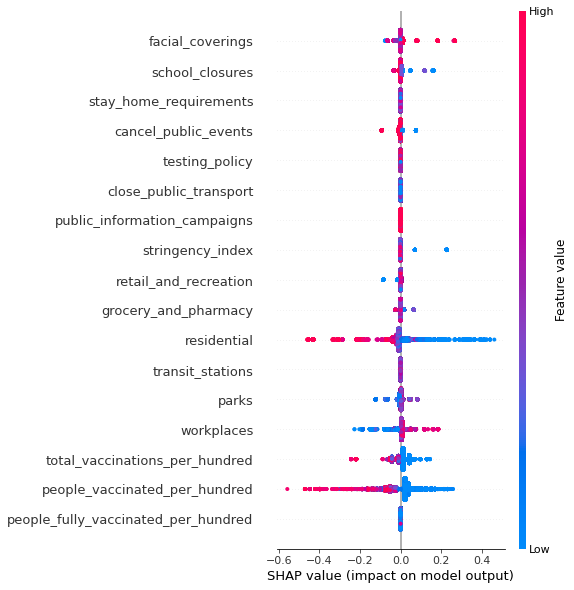

In [86]:

shap.summary_plot(shav_values_df[use_cols].values, 
                  features=X[use_cols], 
                  feature_names=use_cols, 
                  max_display=44,
                  sort=False,
                  use_log_scale=False)

In [87]:
import seaborn as sns; sns.set_theme()

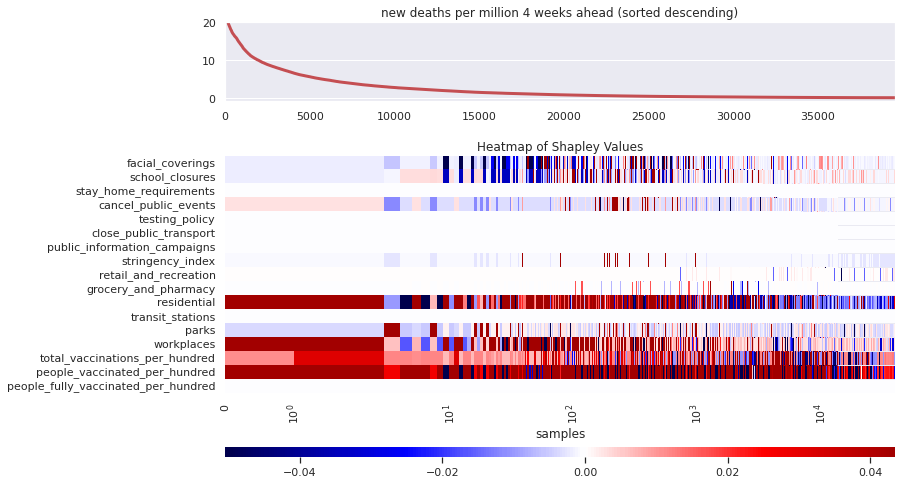

In [88]:
grid_kws = {"height_ratios": (.4, 1.2, .05), "hspace": .5}
fig, (ax1, ax2, cbar_ax) = plt.subplots(3, figsize=(12,8), gridspec_kw=grid_kws)

ax1.set_title('new deaths per million 4 weeks ahead (sorted descending)')
index_sorted = y.values.argsort()[::-1]
ax1.plot(y.values[index_sorted],'r',linewidth=3.0)
ax1.set_xlim(0, y.shape[0])
ax1.set_ylim(-1, 20)
ax1.grid(axis="x")


ax2.set_title('Heatmap of Shapley Values')
ax2 = sns.heatmap(shav_values_df.loc[index_sorted, use_cols].T,
            center=0,
            robust=True,
            cmap='seismic', 
            ax=ax2,
            cbar_ax=cbar_ax,
            cbar_kws={"orientation": "horizontal"})
ax2.set_xlabel('samples')
ax2.set_xscale('symlog')
plt.show()

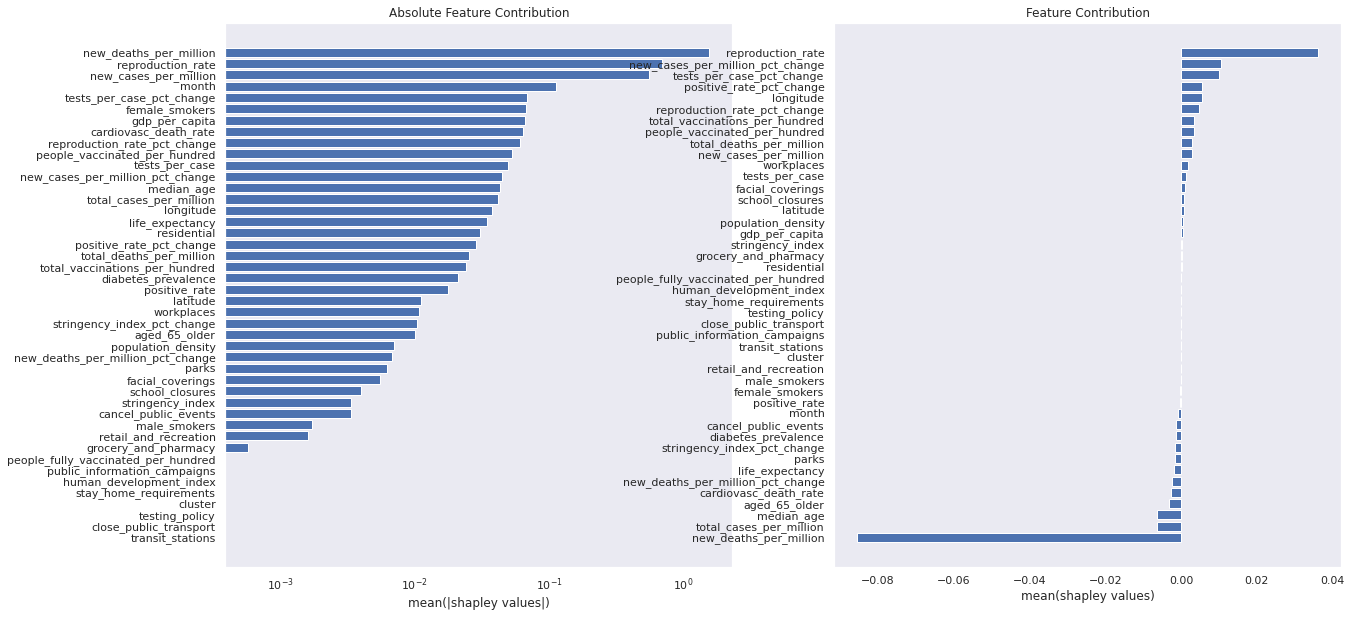

In [89]:
# Make barplot
fig, ax = plt.subplots(1,2,figsize=(20,10))

absolute_feature_contribution = shav_values_df.abs().mean().sort_values()
ax[0].barh(y=absolute_feature_contribution.index,
           width=absolute_feature_contribution.values)
ax[0].set_xscale('log')
ax[0].set_title('Absolute Feature Contribution')
ax[0].set_xlabel('mean(|shapley values|)')
ax[0].grid()


feature_contribution = shav_values_df.mean().sort_values()
ax[1].barh(y=feature_contribution.index,
           width=feature_contribution.values)
ax[1].set_title('Feature Contribution')
ax[1].set_xlabel('mean(shapley values)')
ax[1].grid()


In [90]:
for feat in shap_values.feature_names:

  fig, ax = plt.subplots(nrows=1,
                         ncols=2,
                         figsize=(16,5), 
                         sharex=True, 
                         gridspec_kw={'width_ratios': [0.85, 1]})
  #fig.tight_layout()

  ax[0].set_title('Partial Dependence Plot')
  ax[0].scatter(x=X[feat], 
                y=y,
                s=2,
                alpha=0.5)
  ax[0].set_xlabel(feat, fontsize=12.0)
  ax[0].set_ylabel('new_deaths_per_million', fontsize=12.0)
  ax[0].grid(axis="x")

  

  ax[1].set_title('SHAP Dependence Plot')
  ax[1].grid(axis="x")
  shap.dependence_plot(ind=feat, 
                      shap_values=shap_values.values, 
                      features=shap_values.data, 
                      feature_names=X.columns,
                      interaction_index='new_deaths_per_million',
                      x_jitter=1,
                      alpha=0.5,
                      #xmin=-5,
                      #xmax=105,
                      ax = ax[1],
                      show=True)


Output hidden; open in https://colab.research.google.com to view.

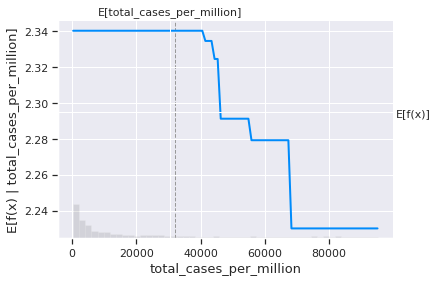

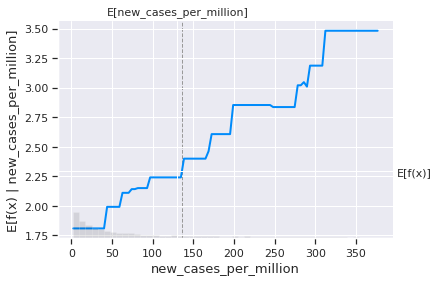

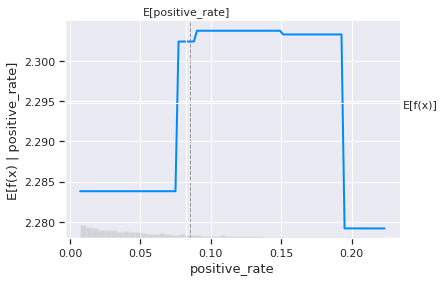

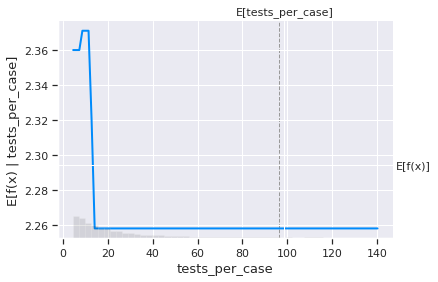

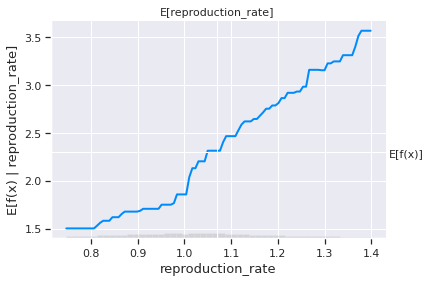

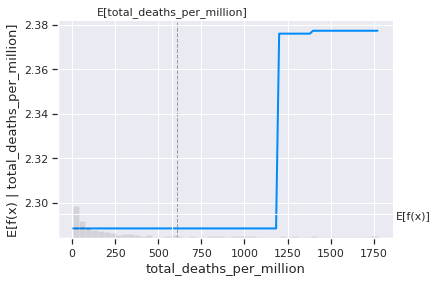

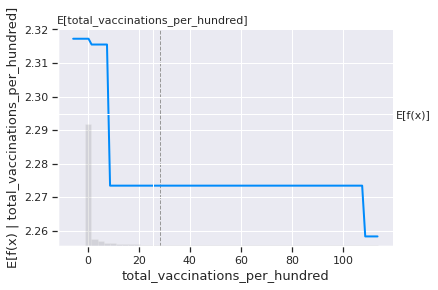

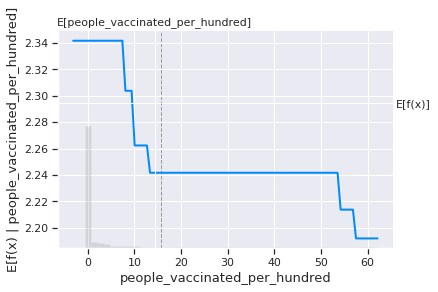

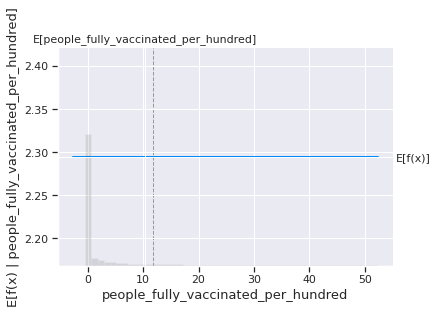

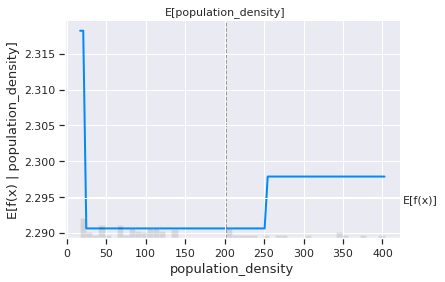

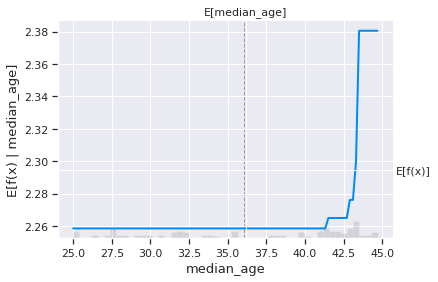

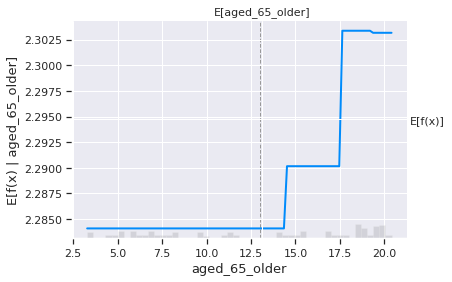

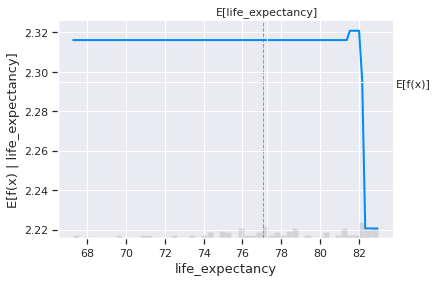

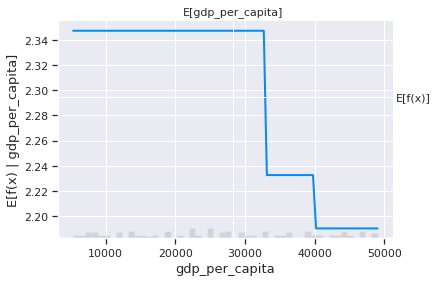

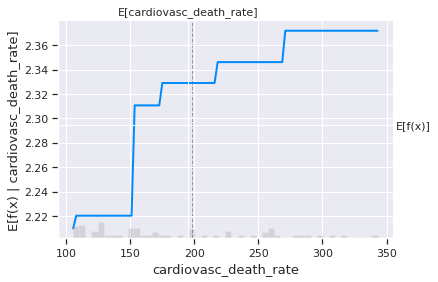

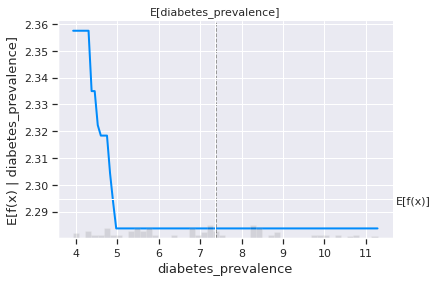

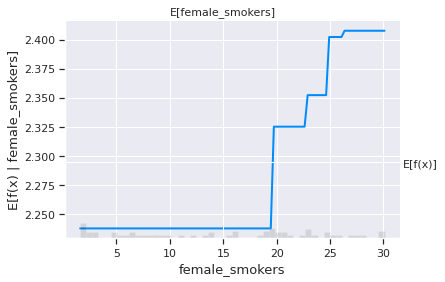

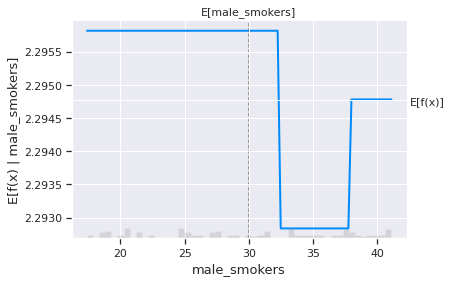

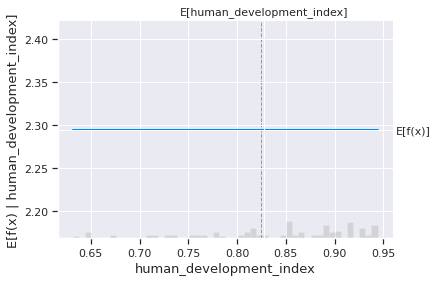

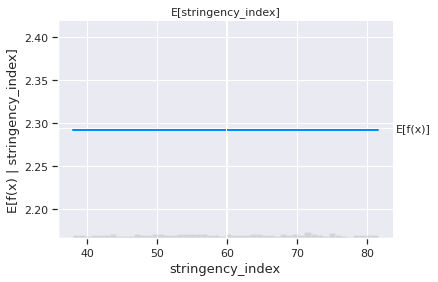

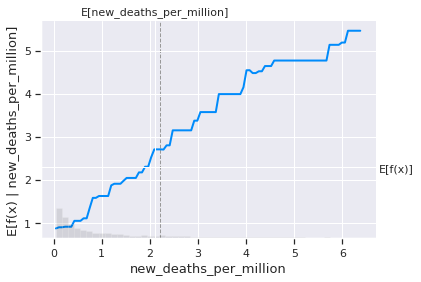

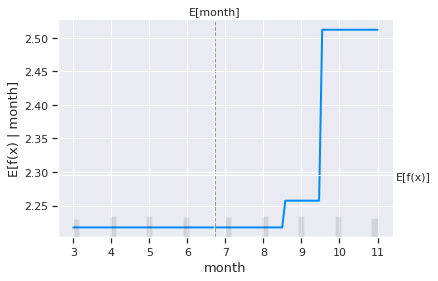

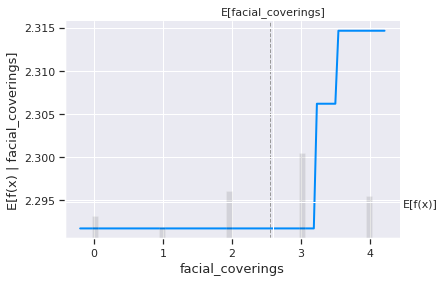

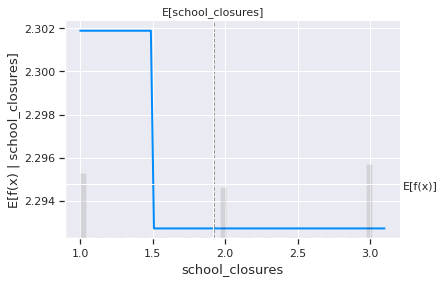

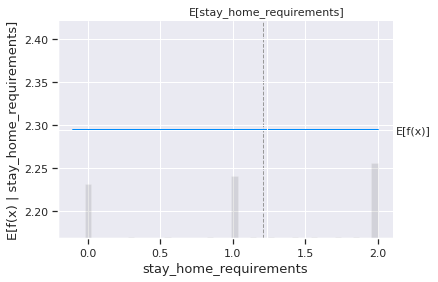

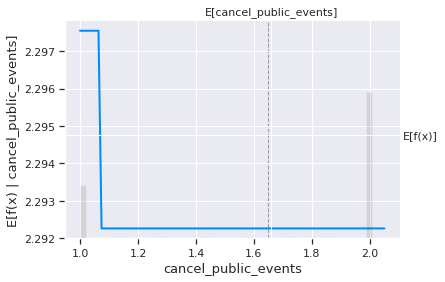

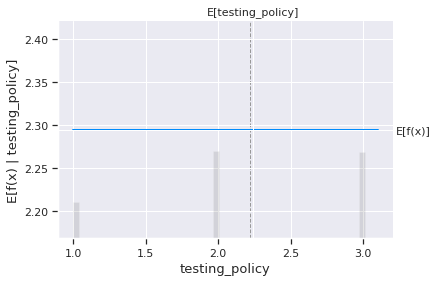

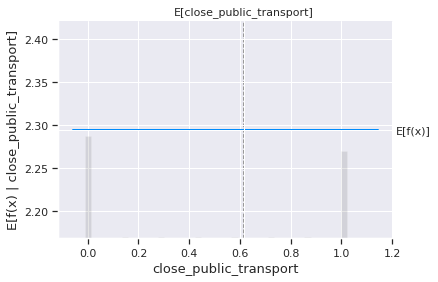

Attempting to set identical left == right == 2.0 results in singular transformations; automatically expanding.


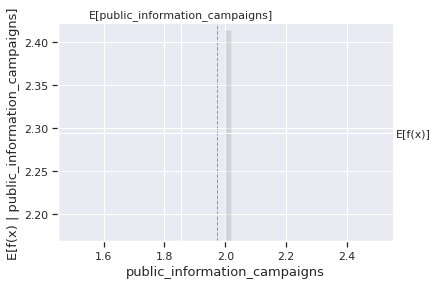

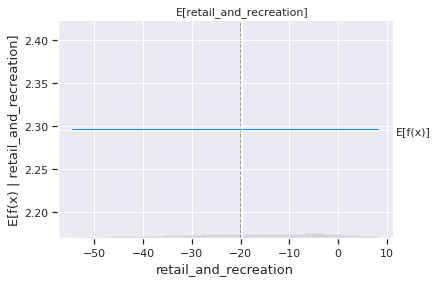

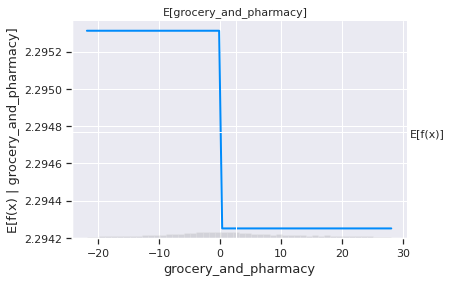

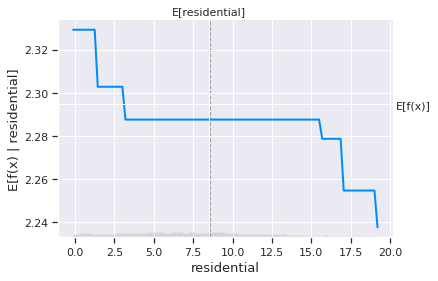

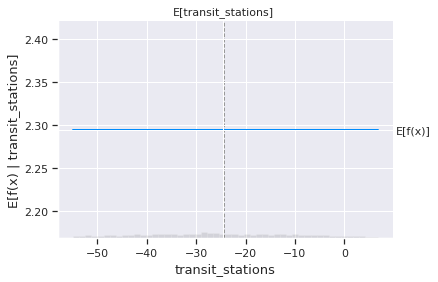

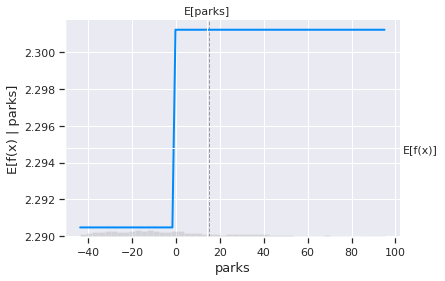

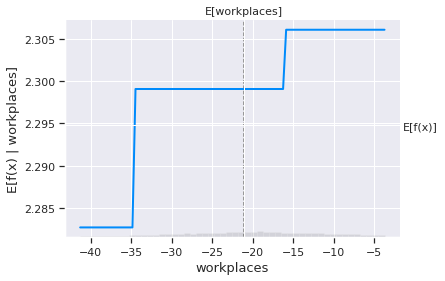

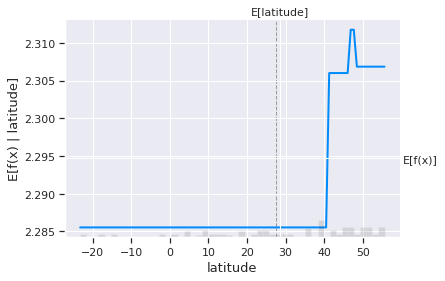

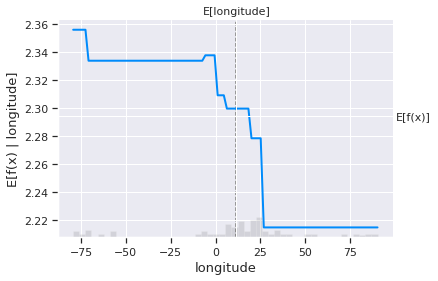

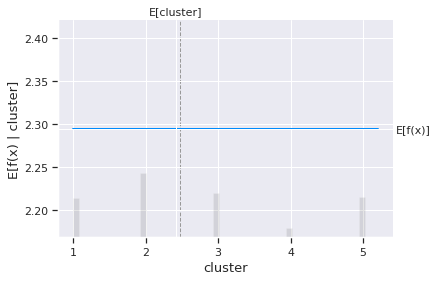

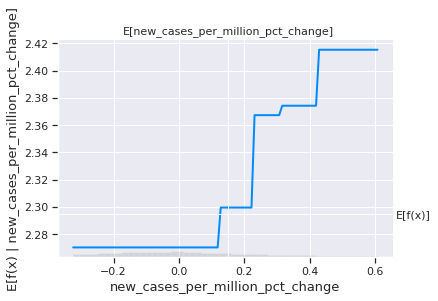

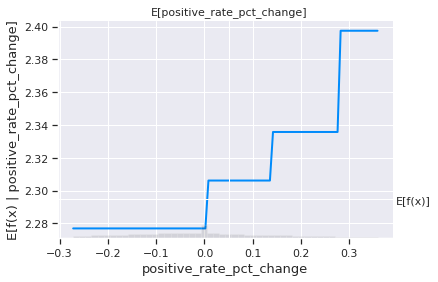

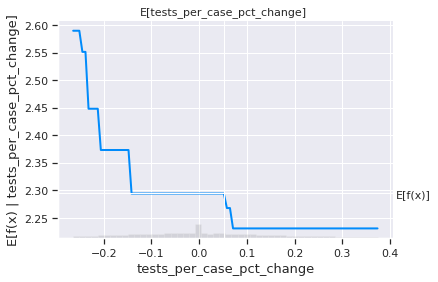

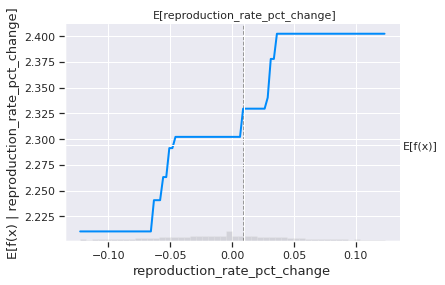

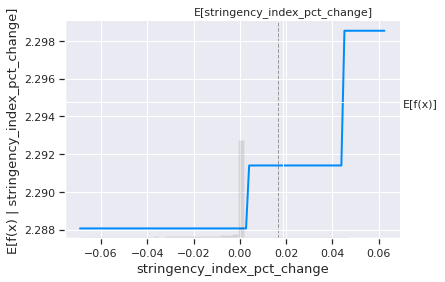

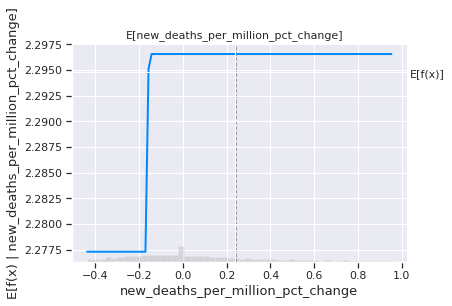

In [91]:
for feat in shap_values.feature_names:
  shap.partial_dependence_plot(ind=feat, 
                              model=reg_tuned.predict, 
                              data=X, 
                              xmin='percentile(10)', 
                              xmax='percentile(90)', 
                              npoints=100, 
                              feature_names=None, 
                              hist=True, 
                              model_expected_value=True, 
                              feature_expected_value=True, 
                              shap_values=None,  
                              ylabel=None, 
                              ice=False, 
                              ace_opacity=1, 
                              pd_opacity=1, 
                              pd_linewidth=2, 
                              ace_linewidth='auto', 
                              ax=None, 
                              show=True)

## Considere Summary Contributions Adding Multiple Effects

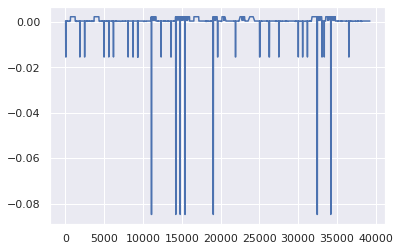

In [92]:
ind = shav_data_df[mobility_vars[0]] < 0
shav_values_df[mobility_vars[0]][ind].plot()

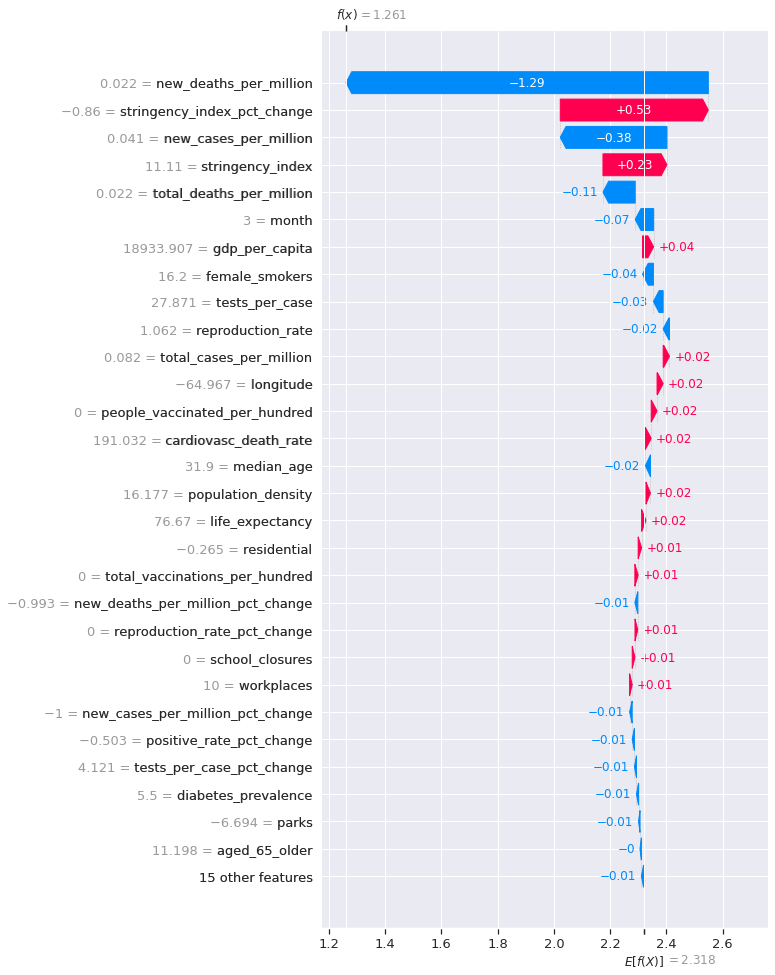

In [93]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=30)

In [94]:
shap.initjs()

In [95]:
explainer = shap.TreeExplainer(reg_tuned)
shap_values = explainer.shap_values(X)

In [96]:
#country = 'France'
#country = 'Germany'
#country = 'Sweden'


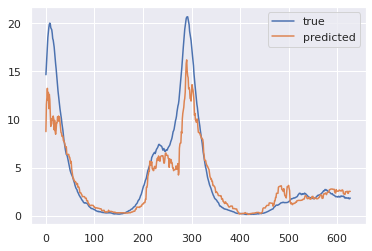

In [97]:
country = 'United Kingdom'
df_country = filter_country(data_csv, country)

X = df_country[features]
y = df_country[target]

plt.plot(y.values)
plt.plot(reg_tuned.predict(X))
plt.legend(['true', 'predicted'])

In [98]:
explainer = shap.Explainer(reg_tuned)
shap_values = explainer(X)

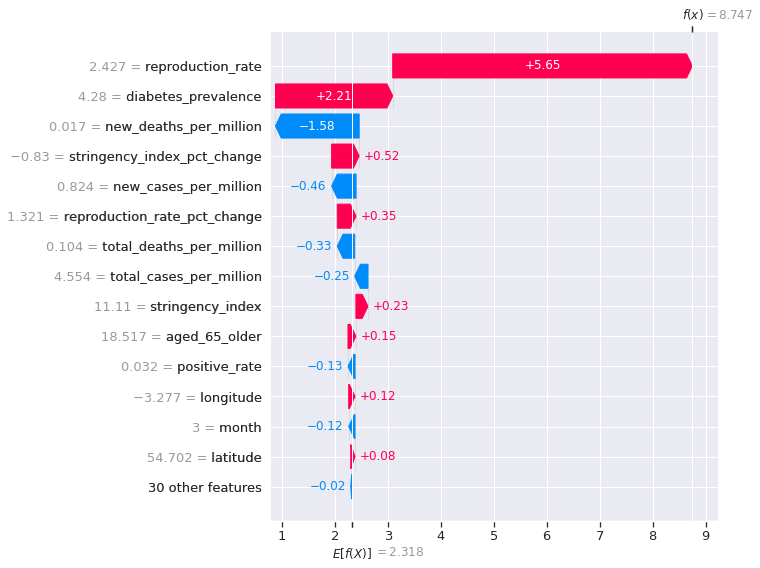

In [99]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=15)

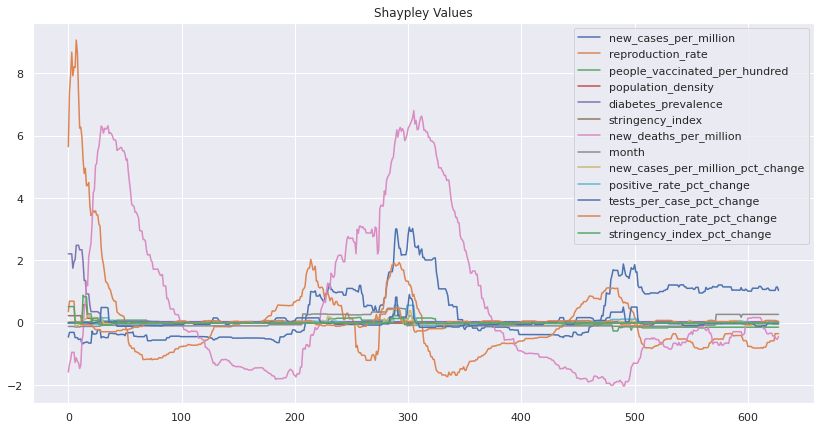

In [100]:
plt.figure(figsize=(14,7))
legend=[]
for col in range(len(X.columns)):
  y1 = shap_values.values[:,col]
  if y1.max()>0.2:
    legend.append(X.columns[col])
    plt.plot(y1)
    plt.title('Shaypley Values')
  plt.legend(legend)
  plt.grid('on')

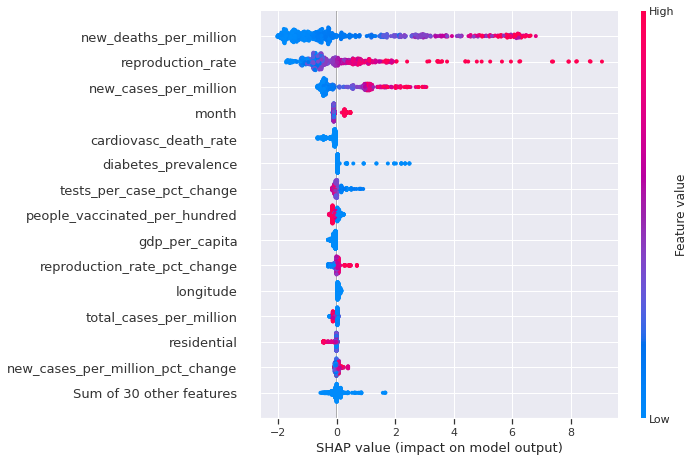

In [101]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=15)

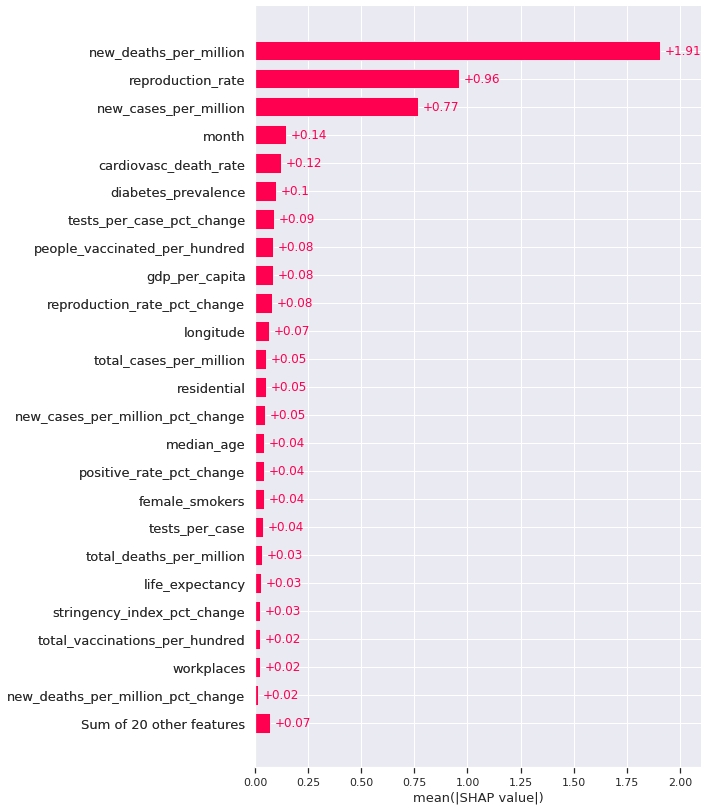

In [102]:
shap.plots.bar(shap_values, max_display=25)

In [103]:
# ToDo
# korrigiere Ausreiser
# zeige Zeitverläufe der SHAP Werte
# encodiere Continent als weitere Gruppierung
# hyperparameter tune modell!!!